# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in
TensorFlow.  For example, suppose we are building a biological reinforcement learning
model, but we'd like the inputs to our model to be natural images rather than artificial
vectors.  We could load a vision network from TensorFlow, insert it into our model using
NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the
[TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to
write code directly in TensorFlow, and then insert it easily into Nengo.  In this
example we will demonstrate how to integrate a Keras network into a Nengo model in a
series of stages. First, inserting an entire Keras model, second, inserting individual
Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the
node to insert Python code into our model we will use it to insert TensorFlow code.

The first thing we need to do is define our TensorNode output.  This is a function that
accepts the current simulation time (and, optionally, a batch of vectors) as input, and
produces a batch of vectors as output.  All of these variables will be represented as
`tf.Tensor` objects, and the internal operations of the TensorNode will be implemented
with TensorFlow operations. For example, we could use a TensorNode to output a `sin`
function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

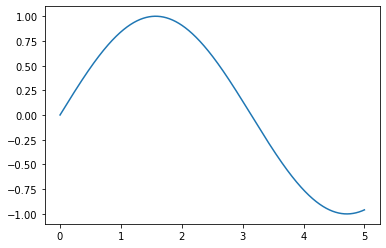

In [2]:
with nengo.Network() as net:

    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)

        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))

        return output

    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)

plt.figure()
plt.plot(sim.trange(), sim.data[p])
plt.show()

However, outputting a `sin` function is something we could do more easily with a regular
`nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more
complex TensorFlow code and insert it into a NengoDL model. For example, one thing we
often want to do is take a deep network written in TensorFlow/Keras, and add it into a
Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software
package for building and training deep learning style networks.  It is a higher-level
API within TensorFlow to make it easier to construct and train deep networks.  And
because it is all implemented as a TensorFlow network under the hood, we can define a
network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the
[introduction in the Tensorflow
documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are
not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.
This dataset contains images of clothing, and the goal of the network is to identify
what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

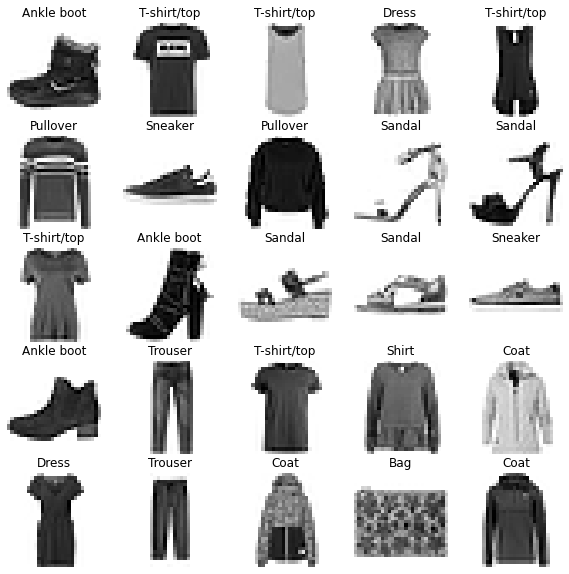

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're
building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in
NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do
everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 16:35 - loss: 2.2751 - accuracy: 0.0938

  37/1875 [..............................] - ETA: 2s - loss: 1.2581 - accuracy: 0.5625   

  73/1875 [>.............................] - ETA: 2s - loss: 1.0259 - accuracy: 0.6370

 109/1875 [>.............................] - ETA: 2s - loss: 0.9050 - accuracy: 0.6821

 143/1875 [=>............................] - ETA: 2s - loss: 0.8378 - accuracy: 0.7050

 180/1875 [=>............................]

 - ETA: 2s - loss: 0.7936 - accuracy: 0.7208

 217/1875 [==>...........................] - ETA: 2s - loss: 0.7614 - accuracy: 0.7326

 254/1875 [===>..........................] - ETA: 2s - loss: 0.7305 - accuracy: 0.7442

 291/1875 [===>..........................] - ETA: 2s - loss: 0.7050 - accuracy: 0.7527

 328/1875 [====>.........................] - ETA: 2s - loss: 0.6912 - accuracy: 0.7566

 365/1875 [====>.........................] - ETA: 2s - loss: 0.6757 - accuracy: 0.7625

 402/1875 [=====>........................] - ETA: 2s - loss: 0.6654 - accuracy: 0.7668

 439/1875 [======>.......................] - ETA: 1s - loss: 0.6530 - accuracy: 0.7711

 476/1875 [======>.......................] - ETA: 1s - loss: 0.6406 - accuracy: 0.7757

 513/1875 [=======>......................] - ETA: 1s - loss: 0.6342 - accuracy: 0.7774

 550/1875 [=======>......................] - ETA: 1s - loss: 0.6244 - accuracy: 0.7809

 588/1875 [========>.....................] - ETA: 1s - loss: 0.6187 - accuracy: 0.7829

 625/1875 [=========>....................] - ETA: 1s - loss: 0.6116 - accuracy: 0.7855

 662/1875 [=========>....................] - ETA: 1s - loss: 0.6048 - accuracy: 0.7886

 700/1875 [==========>...................] - ETA: 1s - loss: 0.5963 - accuracy: 0.7917

 737/1875 [==========>...................] - ETA: 1s - loss: 0.5907 - accuracy: 0.7934

 775/1875 [===========>..................] - ETA: 1s - loss: 0.5855 - accuracy: 0.7941

 811/1875 [===========>..................] - ETA: 1s - loss: 0.5796 - accuracy: 0.7957

 848/1875 [============>.................] - ETA: 1s - loss: 0.5775 - accuracy: 0.7962

 885/1875 [=============>................] - ETA: 1s - loss: 0.5734 - accuracy: 0.7981

 922/1875 [=============>................] - ETA: 1s - loss: 0.5658 - accuracy: 0.8012

 957/1875 [==============>...............] - ETA: 1s - loss: 0.5631 - accuracy: 0.8023

 994/1875 [==============>...............] - ETA: 1s - loss: 0.5586 - accuracy: 0.8037

1031/1875 [===============>..............] - ETA: 1s - loss: 0.5536 - accuracy: 0.8052

1067/1875 [================>.............] - ETA: 1s - loss: 0.5506 - accuracy: 0.8064

1104/1875 [================>.............] - ETA: 1s - loss: 0.5471 - accuracy: 0.8077

1139/1875 [=================>............] - ETA: 1s - loss: 0.5435 - accuracy: 0.8089

1176/1875 [=================>............] - ETA: 0s - loss: 0.5402 - accuracy: 0.8099

1212/1875 [==================>...........] - ETA: 0s - loss: 0.5366 - accuracy: 0.8110

1248/1875 [==================>...........] - ETA: 0s - loss: 0.5338 - accuracy: 0.8120

1283/1875 [===================>..........] - ETA: 0s - loss: 0.5317 - accuracy: 0.8130

1321/1875 [====================>.........] - ETA: 0s - loss: 0.5296 - accuracy: 0.8138

1357/1875 [====================>.........] - ETA: 0s - loss: 0.5275 - accuracy: 0.8145

1389/1875 [=====================>........] - ETA: 0s - loss: 0.5252 - accuracy: 0.8153

1424/1875 [=====================>........] - ETA: 0s - loss: 0.5221 - accuracy: 0.8162

1460/1875 [======================>.......] - ETA: 0s - loss: 0.5197 - accuracy: 0.8171

1497/1875 [======================>.......] - ETA: 0s - loss: 0.5167 - accuracy: 0.8181

1528/1875 [=======================>......] - ETA: 0s - loss: 0.5154 - accuracy: 0.8186

1565/1875 [========================>.....] - ETA: 0s - loss: 0.5140 - accuracy: 0.8189

1602/1875 [========================>.....] - ETA: 0s - loss: 0.5128 - accuracy: 0.8193

1638/1875 [=========================>....] - ETA: 0s - loss: 0.5104 - accuracy: 0.8201

1675/1875 [=========================>....] - ETA: 0s - loss: 0.5079 - accuracy: 0.8209

1712/1875 [==========================>...] - ETA: 0s - loss: 0.5073 - accuracy: 0.8214

1749/1875 [==========================>...] - ETA: 0s - loss: 0.5044 - accuracy: 0.8224

1786/1875 [===========================>..] - ETA: 0s - loss: 0.5025 - accuracy: 0.8232

1821/1875 [============================>.] - ETA: 0s - loss: 0.5012 - accuracy: 0.8236

1857/1875 [============================>.] - ETA: 0s - loss: 0.5004 - accuracy: 0.8240

1875/1875 [==============================] - 3s 1ms/step - loss: 0.4996 - accuracy: 0.8242


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1616 - accuracy: 0.9375

  38/1875 [..............................] - ETA: 2s - loss: 0.3757 - accuracy: 0.8717

  74/1875 [>.............................] - ETA: 2s - loss: 0.3680 - accuracy: 0.8725

 111/1875 [>.............................] - ETA: 2s - loss: 0.3889 - accuracy: 0.8663

 147/1875 [=>............................] - ETA: 2s - loss: 0.3929 - accuracy: 0.8625

 184/1875 [=>............................] - ETA: 2s - loss: 0.3980 - accuracy: 0.8590

 220/1875 [==>...........................] - ETA: 2s - loss: 0.3918 - accuracy: 0.8609

 257/1875 [===>..........................] - ETA: 2s - loss: 0.3896 - accuracy: 0.8600

 289/1875 [===>..........................] - ETA: 2s - loss: 0.3979 - accuracy: 0.8563

 326/1875 [====>.........................] - ETA: 2s - loss: 0.3970 - accuracy: 0.8569

 363/1875 [====>.........................] - ETA: 2s - loss: 0.3909 - accuracy: 0.8596

 400/1875 [=====>........................] - ETA: 2s - loss: 0.3880 - accuracy: 0.8590

 437/1875 [=====>........................] - ETA: 2s - loss: 0.3875 - accuracy: 0.8601

 473/1875 [======>.......................] - ETA: 1s - loss: 0.3873 - accuracy: 0.8593

 510/1875 [=======>......................] - ETA: 1s - loss: 0.3872 - accuracy: 0.8594

 547/1875 [=======>......................] - ETA: 1s - loss: 0.3842 - accuracy: 0.8609

 585/1875 [========>.....................] - ETA: 1s - loss: 0.3860 - accuracy: 0.8599

 621/1875 [========>.....................] - ETA: 1s - loss: 0.3860 - accuracy: 0.8601

 658/1875 [=========>....................] - ETA: 1s - loss: 0.3864 - accuracy: 0.8601

 694/1875 [==========>...................] - ETA: 1s - loss: 0.3843 - accuracy: 0.8609

 731/1875 [==========>...................] - ETA: 1s - loss: 0.3862 - accuracy: 0.8602

 767/1875 [===========>..................] - ETA: 1s - loss: 0.3861 - accuracy: 0.8603

 804/1875 [===========>..................] - ETA: 1s - loss: 0.3869 - accuracy: 0.8601

 840/1875 [============>.................] - ETA: 1s - loss: 0.3862 - accuracy: 0.8607

 873/1875 [============>.................] - ETA: 1s - loss: 0.3834 - accuracy: 0.8621

 905/1875 [=============>................] - ETA: 1s - loss: 0.3838 - accuracy: 0.8622

 942/1875 [==============>...............] - ETA: 1s - loss: 0.3826 - accuracy: 0.8624

 979/1875 [==============>...............] - ETA: 1s - loss: 0.3818 - accuracy: 0.8623

1016/1875 [===============>..............] - ETA: 1s - loss: 0.3819 - accuracy: 0.8621

1051/1875 [===============>..............] - ETA: 1s - loss: 0.3814 - accuracy: 0.8626

1089/1875 [================>.............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8632

1126/1875 [=================>............] - ETA: 1s - loss: 0.3778 - accuracy: 0.8641

1164/1875 [=================>............] - ETA: 0s - loss: 0.3782 - accuracy: 0.8641

1198/1875 [==================>...........] - ETA: 0s - loss: 0.3782 - accuracy: 0.8642

1235/1875 [==================>...........] - ETA: 0s - loss: 0.3788 - accuracy: 0.8640

1272/1875 [===================>..........] - ETA: 0s - loss: 0.3794 - accuracy: 0.8637

1309/1875 [===================>..........] - ETA: 0s - loss: 0.3803 - accuracy: 0.8630

1346/1875 [====================>.........] - ETA: 0s - loss: 0.3805 - accuracy: 0.8630

1380/1875 [=====================>........] - ETA: 0s - loss: 0.3797 - accuracy: 0.8633

1417/1875 [=====================>........] - ETA: 0s - loss: 0.3780 - accuracy: 0.8639

1454/1875 [======================>.......] - ETA: 0s - loss: 0.3790 - accuracy: 0.8636

1488/1875 [======================>.......] - ETA: 0s - loss: 0.3787 - accuracy: 0.8639

1525/1875 [=======================>......] - ETA: 0s - loss: 0.3784 - accuracy: 0.8639

1561/1875 [=======================>......] - ETA: 0s - loss: 0.3789 - accuracy: 0.8636

1599/1875 [========================>.....] - ETA: 0s - loss: 0.3790 - accuracy: 0.8636

1625/1875 [=========================>....] - ETA: 0s - loss: 0.3787 - accuracy: 0.8637

1662/1875 [=========================>....] - ETA: 0s - loss: 0.3776 - accuracy: 0.8641

1698/1875 [==========================>...] - ETA: 0s - loss: 0.3778 - accuracy: 0.8641

1736/1875 [==========================>...] - ETA: 0s - loss: 0.3776 - accuracy: 0.8640

1773/1875 [===========================>..] - ETA: 0s - loss: 0.3770 - accuracy: 0.8641

1810/1875 [===========================>..] - ETA: 0s - loss: 0.3766 - accuracy: 0.8643

1842/1875 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.8648

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3752 - accuracy: 0.8652


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.5096 - accuracy: 0.8438

  37/1875 [..............................] - ETA: 2s - loss: 0.3396 - accuracy: 0.8784

  74/1875 [>.............................] - ETA: 2s - loss: 0.3646 - accuracy: 0.8678

 110/1875 [>.............................] - ETA: 2s - loss: 0.3582 - accuracy: 0.8682

 146/1875 [=>............................] - ETA: 2s - loss: 0.3528 - accuracy: 0.8696

 183/1875 [=>............................] - ETA: 2s - loss: 0.3436 - accuracy: 0.8733

 220/1875 [==>...........................] - ETA: 2s - loss: 0.3388 - accuracy: 0.8753

 257/1875 [===>..........................] - ETA: 2s - loss: 0.3362 - accuracy: 0.8751

 294/1875 [===>..........................] - ETA: 2s - loss: 0.3370 - accuracy: 0.8757

 330/1875 [====>.........................] - ETA: 2s - loss: 0.3363 - accuracy: 0.8761

 367/1875 [====>.........................] - ETA: 2s - loss: 0.3355 - accuracy: 0.8768

 404/1875 [=====>........................] - ETA: 2s - loss: 0.3371 - accuracy: 0.8758

 441/1875 [======>.......................] - ETA: 1s - loss: 0.3357 - accuracy: 0.8759

 478/1875 [======>.......................] - ETA: 1s - loss: 0.3375 - accuracy: 0.8761

 514/1875 [=======>......................] - ETA: 1s - loss: 0.3385 - accuracy: 0.8755

 551/1875 [=======>......................] - ETA: 1s - loss: 0.3406 - accuracy: 0.8751

 588/1875 [========>.....................] - ETA: 1s - loss: 0.3381 - accuracy: 0.8761

 624/1875 [========>.....................] - ETA: 1s - loss: 0.3383 - accuracy: 0.8762

 661/1875 [=========>....................] - ETA: 1s - loss: 0.3391 - accuracy: 0.8756

 698/1875 [==========>...................] - ETA: 1s - loss: 0.3404 - accuracy: 0.8746

 735/1875 [==========>...................] - ETA: 1s - loss: 0.3406 - accuracy: 0.8744

 771/1875 [===========>..................] - ETA: 1s - loss: 0.3417 - accuracy: 0.8739

 807/1875 [===========>..................] - ETA: 1s - loss: 0.3423 - accuracy: 0.8737

 844/1875 [============>.................] - ETA: 1s - loss: 0.3418 - accuracy: 0.8739

 877/1875 [=============>................] - ETA: 1s - loss: 0.3401 - accuracy: 0.8747

 914/1875 [=============>................] - ETA: 1s - loss: 0.3389 - accuracy: 0.8753

 951/1875 [==============>...............] - ETA: 1s - loss: 0.3377 - accuracy: 0.8755

 987/1875 [==============>...............] - ETA: 1s - loss: 0.3381 - accuracy: 0.8751

1024/1875 [===============>..............] - ETA: 1s - loss: 0.3385 - accuracy: 0.8750

1061/1875 [===============>..............] - ETA: 1s - loss: 0.3372 - accuracy: 0.8754

1098/1875 [================>.............] - ETA: 1s - loss: 0.3377 - accuracy: 0.8754

1134/1875 [=================>............] - ETA: 1s - loss: 0.3371 - accuracy: 0.8760

1170/1875 [=================>............] - ETA: 0s - loss: 0.3372 - accuracy: 0.8758

1208/1875 [==================>...........] - ETA: 0s - loss: 0.3358 - accuracy: 0.8763

1246/1875 [==================>...........] - ETA: 0s - loss: 0.3349 - accuracy: 0.8770

1283/1875 [===================>..........] - ETA: 0s - loss: 0.3349 - accuracy: 0.8770

1320/1875 [====================>.........] - ETA: 0s - loss: 0.3335 - accuracy: 0.8774

1357/1875 [====================>.........] - ETA: 0s - loss: 0.3352 - accuracy: 0.8769

1394/1875 [=====================>........] - ETA: 0s - loss: 0.3361 - accuracy: 0.8768

1431/1875 [=====================>........] - ETA: 0s - loss: 0.3363 - accuracy: 0.8766

1468/1875 [======================>.......] - ETA: 0s - loss: 0.3360 - accuracy: 0.8767

1504/1875 [=======================>......] - ETA: 0s - loss: 0.3361 - accuracy: 0.8768

1541/1875 [=======================>......] - ETA: 0s - loss: 0.3375 - accuracy: 0.8764

1578/1875 [========================>.....] - ETA: 0s - loss: 0.3382 - accuracy: 0.8761

1614/1875 [========================>.....] - ETA: 0s - loss: 0.3377 - accuracy: 0.8763

1650/1875 [=========================>....] - ETA: 0s - loss: 0.3383 - accuracy: 0.8761

1688/1875 [==========================>...] - ETA: 0s - loss: 0.3373 - accuracy: 0.8765

1725/1875 [==========================>...] - ETA: 0s - loss: 0.3377 - accuracy: 0.8762

1762/1875 [===========================>..] - ETA: 0s - loss: 0.3376 - accuracy: 0.8762

1798/1875 [===========================>..] - ETA: 0s - loss: 0.3372 - accuracy: 0.8765

1835/1875 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8767

1871/1875 [============================>.] - ETA: 0s - loss: 0.3369 - accuracy: 0.8766

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3371 - accuracy: 0.8765


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.2060 - accuracy: 0.9062

  38/1875 [..............................] - ETA: 2s - loss: 0.3341 - accuracy: 0.8725

  75/1875 [>.............................] - ETA: 2s - loss: 0.3342 - accuracy: 0.8725

 112/1875 [>.............................] - ETA: 2s - loss: 0.3163 - accuracy: 0.8823

 148/1875 [=>............................] - ETA: 2s - loss: 0.3077 - accuracy: 0.8828

 182/1875 [=>............................] - ETA: 2s - loss: 0.3145 - accuracy: 0.8805

 219/1875 [==>...........................] - ETA: 2s - loss: 0.3105 - accuracy: 0.8827

 256/1875 [===>..........................] - ETA: 2s - loss: 0.3099 - accuracy: 0.8835

 292/1875 [===>..........................] - ETA: 2s - loss: 0.3114 - accuracy: 0.8833

 329/1875 [====>.........................] - ETA: 2s - loss: 0.3110 - accuracy: 0.8836

 366/1875 [====>.........................] - ETA: 2s - loss: 0.3125 - accuracy: 0.8829

 403/1875 [=====>........................] - ETA: 2s - loss: 0.3129 - accuracy: 0.8831

 440/1875 [======>.......................] - ETA: 1s - loss: 0.3111 - accuracy: 0.8843

 462/1875 [======>.......................] - ETA: 2s - loss: 0.3104 - accuracy: 0.8849

 499/1875 [======>.......................] - ETA: 1s - loss: 0.3107 - accuracy: 0.8842

 536/1875 [=======>......................] - ETA: 1s - loss: 0.3085 - accuracy: 0.8854

 573/1875 [========>.....................] - ETA: 1s - loss: 0.3089 - accuracy: 0.8857

 609/1875 [========>.....................] - ETA: 1s - loss: 0.3097 - accuracy: 0.8849

 646/1875 [=========>....................] - ETA: 1s - loss: 0.3096 - accuracy: 0.8848

 679/1875 [=========>....................] - ETA: 1s - loss: 0.3111 - accuracy: 0.8842

 714/1875 [==========>...................] - ETA: 1s - loss: 0.3109 - accuracy: 0.8842

 749/1875 [==========>...................] - ETA: 1s - loss: 0.3100 - accuracy: 0.8845

 783/1875 [===========>..................] - ETA: 1s - loss: 0.3088 - accuracy: 0.8849

 818/1875 [============>.................] - ETA: 1s - loss: 0.3079 - accuracy: 0.8855

 853/1875 [============>.................] - ETA: 1s - loss: 0.3085 - accuracy: 0.8853

 889/1875 [=============>................] - ETA: 1s - loss: 0.3080 - accuracy: 0.8857

 925/1875 [=============>................] - ETA: 1s - loss: 0.3077 - accuracy: 0.8856

 962/1875 [==============>...............] - ETA: 1s - loss: 0.3081 - accuracy: 0.8854

 999/1875 [==============>...............] - ETA: 1s - loss: 0.3082 - accuracy: 0.8859

1035/1875 [===============>..............] - ETA: 1s - loss: 0.3085 - accuracy: 0.8862

1072/1875 [================>.............] - ETA: 1s - loss: 0.3101 - accuracy: 0.8855

1108/1875 [================>.............] - ETA: 1s - loss: 0.3094 - accuracy: 0.8857

1145/1875 [=================>............] - ETA: 1s - loss: 0.3090 - accuracy: 0.8859

1182/1875 [=================>............] - ETA: 0s - loss: 0.3098 - accuracy: 0.8855

1214/1875 [==================>...........] - ETA: 0s - loss: 0.3092 - accuracy: 0.8857

1249/1875 [==================>...........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8855

1283/1875 [===================>..........] - ETA: 0s - loss: 0.3096 - accuracy: 0.8854

1318/1875 [====================>.........] - ETA: 0s - loss: 0.3092 - accuracy: 0.8856

1355/1875 [====================>.........] - ETA: 0s - loss: 0.3091 - accuracy: 0.8857

1392/1875 [=====================>........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8859

1429/1875 [=====================>........] - ETA: 0s - loss: 0.3093 - accuracy: 0.8862

1464/1875 [======================>.......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8858

1501/1875 [=======================>......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8857

1537/1875 [=======================>......] - ETA: 0s - loss: 0.3098 - accuracy: 0.8856

1574/1875 [========================>.....] - ETA: 0s - loss: 0.3097 - accuracy: 0.8856

1611/1875 [========================>.....] - ETA: 0s - loss: 0.3104 - accuracy: 0.8854

1648/1875 [=========================>....] - ETA: 0s - loss: 0.3102 - accuracy: 0.8856

1685/1875 [=========================>....] - ETA: 0s - loss: 0.3094 - accuracy: 0.8859

1721/1875 [==========================>...] - ETA: 0s - loss: 0.3092 - accuracy: 0.8861

1758/1875 [===========================>..] - ETA: 0s - loss: 0.3090 - accuracy: 0.8862

1796/1875 [===========================>..] - ETA: 0s - loss: 0.3104 - accuracy: 0.8856

1832/1875 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8852

1868/1875 [============================>.] - ETA: 0s - loss: 0.3115 - accuracy: 0.8850

1875/1875 [==============================] - 3s 1ms/step - loss: 0.3116 - accuracy: 0.8850


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1834 - accuracy: 0.9375

  38/1875 [..............................] - ETA: 2s - loss: 0.3073 - accuracy: 0.8799

  76/1875 [>.............................] - ETA: 2s - loss: 0.2750 - accuracy: 0.8939

 113/1875 [>.............................] - ETA: 2s - loss: 0.2680 - accuracy: 0.8991

 149/1875 [=>............................] - ETA: 2s - loss: 0.2794 - accuracy: 0.8945

 185/1875 [=>............................] - ETA: 2s - loss: 0.2814 - accuracy: 0.8953

 221/1875 [==>...........................] - ETA: 2s - loss: 0.2858 - accuracy: 0.8951

 256/1875 [===>..........................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8939

 293/1875 [===>..........................] - ETA: 2s - loss: 0.2887 - accuracy: 0.8933

 330/1875 [====>.........................] - ETA: 2s - loss: 0.2907 - accuracy: 0.8920

 367/1875 [====>.........................] - ETA: 2s - loss: 0.2898 - accuracy: 0.8935

 403/1875 [=====>........................] - ETA: 2s - loss: 0.2894 - accuracy: 0.8944

 439/1875 [======>.......................] - ETA: 1s - loss: 0.2879 - accuracy: 0.8942

 475/1875 [======>.......................] - ETA: 1s - loss: 0.2873 - accuracy: 0.8941

 511/1875 [=======>......................] - ETA: 1s - loss: 0.2856 - accuracy: 0.8946

 547/1875 [=======>......................] - ETA: 1s - loss: 0.2896 - accuracy: 0.8935

 583/1875 [========>.....................] - ETA: 1s - loss: 0.2912 - accuracy: 0.8926

 620/1875 [========>.....................] - ETA: 1s - loss: 0.2929 - accuracy: 0.8921

 657/1875 [=========>....................] - ETA: 1s - loss: 0.2953 - accuracy: 0.8910

 695/1875 [==========>...................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8914

 731/1875 [==========>...................] - ETA: 1s - loss: 0.2928 - accuracy: 0.8913

 769/1875 [===========>..................] - ETA: 1s - loss: 0.2947 - accuracy: 0.8908

 805/1875 [===========>..................] - ETA: 1s - loss: 0.2929 - accuracy: 0.8917

 842/1875 [============>.................] - ETA: 1s - loss: 0.2920 - accuracy: 0.8919

 879/1875 [=============>................] - ETA: 1s - loss: 0.2921 - accuracy: 0.8922

 917/1875 [=============>................] - ETA: 1s - loss: 0.2931 - accuracy: 0.8916

 955/1875 [==============>...............] - ETA: 1s - loss: 0.2939 - accuracy: 0.8914

 992/1875 [==============>...............] - ETA: 1s - loss: 0.2940 - accuracy: 0.8913

1029/1875 [===============>..............] - ETA: 1s - loss: 0.2929 - accuracy: 0.8913

1062/1875 [===============>..............] - ETA: 1s - loss: 0.2918 - accuracy: 0.8915

1099/1875 [================>.............] - ETA: 1s - loss: 0.2908 - accuracy: 0.8918

1135/1875 [=================>............] - ETA: 1s - loss: 0.2905 - accuracy: 0.8921

1171/1875 [=================>............] - ETA: 0s - loss: 0.2902 - accuracy: 0.8923

1208/1875 [==================>...........] - ETA: 0s - loss: 0.2897 - accuracy: 0.8926

1239/1875 [==================>...........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8917

1276/1875 [===================>..........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8917

1313/1875 [====================>.........] - ETA: 0s - loss: 0.2910 - accuracy: 0.8920

1349/1875 [====================>.........] - ETA: 0s - loss: 0.2910 - accuracy: 0.8920

1384/1875 [=====================>........] - ETA: 0s - loss: 0.2911 - accuracy: 0.8919

1419/1875 [=====================>........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8915

1454/1875 [======================>.......] - ETA: 0s - loss: 0.2930 - accuracy: 0.8911

1490/1875 [======================>.......] - ETA: 0s - loss: 0.2938 - accuracy: 0.8908

1528/1875 [=======================>......] - ETA: 0s - loss: 0.2943 - accuracy: 0.8905

1565/1875 [========================>.....] - ETA: 0s - loss: 0.2937 - accuracy: 0.8907

1603/1875 [========================>.....] - ETA: 0s - loss: 0.2941 - accuracy: 0.8907

1640/1875 [=========================>....] - ETA: 0s - loss: 0.2938 - accuracy: 0.8909

1678/1875 [=========================>....] - ETA: 0s - loss: 0.2934 - accuracy: 0.8911

1716/1875 [==========================>...] - ETA: 0s - loss: 0.2938 - accuracy: 0.8908

1752/1875 [===========================>..] - ETA: 0s - loss: 0.2937 - accuracy: 0.8909

1789/1875 [===========================>..] - ETA: 0s - loss: 0.2934 - accuracy: 0.8910

1824/1875 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8912

1861/1875 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8910

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2937 - accuracy: 0.8910


Test accuracy: 0.8705000281333923


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more
complicated in this case, since we need to load in the model from above and the
pretrained weights.  We can accomplish this by creating a custom Keras Layer, which
allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This
effectively reruns the Keras model definition from above, but because we're calling it
within the `build` stage it will be naturally integrated into the NengoDL model that is
being built.

The `call` function is where we do the main job of constructing the TensorFlow elements
that will implement our node.  It will take TensorFlow Tensors as input and produce a
`tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the
Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement
that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()

        self.model = keras_model

    def build(self, input_shapes):
        super().build(input_shapes)

        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)

        # load the weights we saved above
        self.model.load_weights(model_weights)

    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into
a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in
our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)

    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28 * 28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and
connect them up to the Keras node (for example, if we wanted to take the classified
image labels and use them as input to a spiking neural model).  But to keep things
simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully
loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
with net:
    # we'll disable some features we don't need in this example, to improve
    # the training speed
    nengo_dl.configure_settings(stateful=False, use_loop=False)

minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8705000281333923


We can see that we're getting the same performance in Nengo as we were in Keras,
indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to
integrate a Keras model into Nengo by inserting the individual layers.  This requires
more manual translation work, but it makes it easier to make changes to the model later
on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this
time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to
the TensorNode.  However, we can make this construction process even simpler by using
`nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the
Keras functional layer API. Under the hood it's doing the same thing (creating
TensorNodes and Connections), but it allows us to define the model in a way that looks
very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(
        inp
    )
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL
this time. Fortunately, the API is essentially the same:

In [11]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 18:56 - loss: 2.2471 - probe_loss: 2.2471 - probe_accuracy: 0.1000

  34/3000 [..............................] - ETA: 4s - loss: 1.3071 - probe_loss: 1.3071 - probe_accuracy: 0.5324   

  66/3000 [..............................] - ETA: 4s - loss: 1.0890 - probe_loss: 1.0890 - probe_accuracy: 0.6091

  99/3000 [..............................] - ETA: 4s - loss: 1.0019 - probe_loss: 1.0019 - probe_accuracy: 0.6495

 124/3000 [>.............................] - ETA: 4s - loss: 0.9288 - probe_loss: 0.9288 - probe_accuracy: 0.6730

 157/3000 [>.............................] - ETA: 4s - loss: 0.8697 - probe_loss: 0.8697 - probe_accuracy: 0.6927

 190/3000 [>.............................] - ETA: 4s - loss: 0.8439 - probe_loss: 0.8439 - probe_accuracy: 0.7039

 221/3000 [=>............................] - ETA: 4s - loss: 0.8207 - probe_loss: 0.8207 - probe_accuracy: 0.7131

 254/3000 [=>............................] - ETA: 4s - loss: 0.7957 - probe_loss: 0.7957 - probe_accuracy: 0.7203

 286/3000 [=>............................] - ETA: 4s - loss: 0.7809 - probe_loss: 0.7809 - probe_accuracy: 0.7288

 319/3000 [==>...........................] - ETA: 4s - loss: 0.7633 - probe_loss: 0.7633 - probe_accuracy: 0.7364

 351/3000 [==>...........................] - ETA: 4s - loss: 0.7444 - probe_loss: 0.7444 - probe_accuracy: 0.7426

 384/3000 [==>...........................] - ETA: 4s - loss: 0.7298 - probe_loss: 0.7298 - probe_accuracy: 0.7470

 416/3000 [===>..........................] - ETA: 4s - loss: 0.7168 - probe_loss: 0.7168 - probe_accuracy: 0.7524

 450/3000 [===>..........................] - ETA: 4s - loss: 0.7035 - probe_loss: 0.7035 - probe_accuracy: 0.7567

 482/3000 [===>..........................] - ETA: 3s - loss: 0.6874 - probe_loss: 0.6874 - probe_accuracy: 0.7611

 515/3000 [====>.........................] - ETA: 3s - loss: 0.6787 - probe_loss: 0.6787 - probe_accuracy: 0.7650

 548/3000 [====>.........................] - ETA: 3s - loss: 0.6710 - probe_loss: 0.6710 - probe_accuracy: 0.7683

 581/3000 [====>.........................] - ETA: 3s - loss: 0.6628 - probe_loss: 0.6628 - probe_accuracy: 0.7717

 614/3000 [=====>........................] - ETA: 3s - loss: 0.6559 - probe_loss: 0.6559 - probe_accuracy: 0.7743

 646/3000 [=====>........................] - ETA: 3s - loss: 0.6518 - probe_loss: 0.6518 - probe_accuracy: 0.7755

 679/3000 [=====>........................] - ETA: 3s - loss: 0.6470 - probe_loss: 0.6470 - probe_accuracy: 0.7772

 711/3000 [======>.......................] - ETA: 3s - loss: 0.6391 - probe_loss: 0.6391 - probe_accuracy: 0.7797

 743/3000 [======>.......................] - ETA: 3s - loss: 0.6329 - probe_loss: 0.6329 - probe_accuracy: 0.7820

 776/3000 [======>.......................] - ETA: 3s - loss: 0.6275 - probe_loss: 0.6275 - probe_accuracy: 0.7846

 809/3000 [=======>......................] - ETA: 3s - loss: 0.6224 - probe_loss: 0.6224 - probe_accuracy: 0.7864

 842/3000 [=======>......................] - ETA: 3s - loss: 0.6181 - probe_loss: 0.6181 - probe_accuracy: 0.7879

 875/3000 [=======>......................] - ETA: 3s - loss: 0.6140 - probe_loss: 0.6140 - probe_accuracy: 0.7890

 907/3000 [========>.....................] - ETA: 3s - loss: 0.6106 - probe_loss: 0.6106 - probe_accuracy: 0.7899

 940/3000 [========>.....................] - ETA: 3s - loss: 0.6076 - probe_loss: 0.6076 - probe_accuracy: 0.7909

 972/3000 [========>.....................] - ETA: 3s - loss: 0.6047 - probe_loss: 0.6047 - probe_accuracy: 0.7920

1004/3000 [=========>....................] - ETA: 3s - loss: 0.5992 - probe_loss: 0.5992 - probe_accuracy: 0.7938

1037/3000 [=========>....................] - ETA: 3s - loss: 0.5949 - probe_loss: 0.5949 - probe_accuracy: 0.7954

1070/3000 [=========>....................] - ETA: 3s - loss: 0.5903 - probe_loss: 0.5903 - probe_accuracy: 0.7965

1102/3000 [==========>...................] - ETA: 2s - loss: 0.5861 - probe_loss: 0.5861 - probe_accuracy: 0.7976

1135/3000 [==========>...................] - ETA: 2s - loss: 0.5832 - probe_loss: 0.5832 - probe_accuracy: 0.7983

1168/3000 [==========>...................] - ETA: 2s - loss: 0.5803 - probe_loss: 0.5803 - probe_accuracy: 0.7996

1201/3000 [===========>..................] - ETA: 2s - loss: 0.5761 - probe_loss: 0.5761 - probe_accuracy: 0.8010

1234/3000 [===========>..................] - ETA: 2s - loss: 0.5727 - probe_loss: 0.5727 - probe_accuracy: 0.8021

1267/3000 [===========>..................] - ETA: 2s - loss: 0.5705 - probe_loss: 0.5705 - probe_accuracy: 0.8025

1299/3000 [===========>..................] - ETA: 2s - loss: 0.5671 - probe_loss: 0.5671 - probe_accuracy: 0.8036

1331/3000 [============>.................] - ETA: 2s - loss: 0.5645 - probe_loss: 0.5645 - probe_accuracy: 0.8039

1363/3000 [============>.................] - ETA: 2s - loss: 0.5620 - probe_loss: 0.5620 - probe_accuracy: 0.8048

1393/3000 [============>.................] - ETA: 2s - loss: 0.5593 - probe_loss: 0.5593 - probe_accuracy: 0.8056

1425/3000 [=============>................] - ETA: 2s - loss: 0.5579 - probe_loss: 0.5579 - probe_accuracy: 0.8058

1458/3000 [=============>................] - ETA: 2s - loss: 0.5572 - probe_loss: 0.5572 - probe_accuracy: 0.8062

1490/3000 [=============>................] - ETA: 2s - loss: 0.5554 - probe_loss: 0.5554 - probe_accuracy: 0.8068

1523/3000 [==============>...............] - ETA: 2s - loss: 0.5553 - probe_loss: 0.5553 - probe_accuracy: 0.8069

1544/3000 [==============>...............] - ETA: 2s - loss: 0.5531 - probe_loss: 0.5531 - probe_accuracy: 0.8076

1576/3000 [==============>...............] - ETA: 2s - loss: 0.5498 - probe_loss: 0.5498 - probe_accuracy: 0.8087

1606/3000 [===============>..............] - ETA: 2s - loss: 0.5476 - probe_loss: 0.5476 - probe_accuracy: 0.8096

1636/3000 [===============>..............] - ETA: 2s - loss: 0.5457 - probe_loss: 0.5457 - probe_accuracy: 0.8102

1668/3000 [===============>..............] - ETA: 2s - loss: 0.5427 - probe_loss: 0.5427 - probe_accuracy: 0.8110

1700/3000 [================>.............] - ETA: 2s - loss: 0.5411 - probe_loss: 0.5411 - probe_accuracy: 0.8114

1732/3000 [================>.............] - ETA: 2s - loss: 0.5390 - probe_loss: 0.5390 - probe_accuracy: 0.8120

1765/3000 [================>.............] - ETA: 1s - loss: 0.5374 - probe_loss: 0.5374 - probe_accuracy: 0.8125

1798/3000 [================>.............] - ETA: 1s - loss: 0.5369 - probe_loss: 0.5369 - probe_accuracy: 0.8128

1829/3000 [=================>............] - ETA: 1s - loss: 0.5340 - probe_loss: 0.5340 - probe_accuracy: 0.8138

1862/3000 [=================>............] - ETA: 1s - loss: 0.5323 - probe_loss: 0.5323 - probe_accuracy: 0.8144

1894/3000 [=================>............] - ETA: 1s - loss: 0.5305 - probe_loss: 0.5305 - probe_accuracy: 0.8150

1927/3000 [==================>...........] - ETA: 1s - loss: 0.5286 - probe_loss: 0.5286 - probe_accuracy: 0.8156

1959/3000 [==================>...........] - ETA: 1s - loss: 0.5270 - probe_loss: 0.5270 - probe_accuracy: 0.8160

1992/3000 [==================>...........] - ETA: 1s - loss: 0.5246 - probe_loss: 0.5246 - probe_accuracy: 0.8168

2025/3000 [===================>..........] - ETA: 1s - loss: 0.5230 - probe_loss: 0.5230 - probe_accuracy: 0.8170

2058/3000 [===================>..........] - ETA: 1s - loss: 0.5211 - probe_loss: 0.5211 - probe_accuracy: 0.8178

2091/3000 [===================>..........] - ETA: 1s - loss: 0.5196 - probe_loss: 0.5196 - probe_accuracy: 0.8183

2124/3000 [====================>.........] - ETA: 1s - loss: 0.5187 - probe_loss: 0.5187 - probe_accuracy: 0.8185

2155/3000 [====================>.........] - ETA: 1s - loss: 0.5170 - probe_loss: 0.5170 - probe_accuracy: 0.8190

2187/3000 [====================>.........] - ETA: 1s - loss: 0.5160 - probe_loss: 0.5160 - probe_accuracy: 0.8194

2220/3000 [=====================>........] - ETA: 1s - loss: 0.5137 - probe_loss: 0.5137 - probe_accuracy: 0.8201

2251/3000 [=====================>........] - ETA: 1s - loss: 0.5128 - probe_loss: 0.5128 - probe_accuracy: 0.8201

2283/3000 [=====================>........] - ETA: 1s - loss: 0.5117 - probe_loss: 0.5117 - probe_accuracy: 0.8204

2316/3000 [======================>.......] - ETA: 1s - loss: 0.5108 - probe_loss: 0.5108 - probe_accuracy: 0.8207

2348/3000 [======================>.......] - ETA: 1s - loss: 0.5098 - probe_loss: 0.5098 - probe_accuracy: 0.8210

2381/3000 [======================>.......] - ETA: 0s - loss: 0.5079 - probe_loss: 0.5079 - probe_accuracy: 0.8216

2413/3000 [=======================>......] - ETA: 0s - loss: 0.5064 - probe_loss: 0.5064 - probe_accuracy: 0.8222

2445/3000 [=======================>......] - ETA: 0s - loss: 0.5045 - probe_loss: 0.5045 - probe_accuracy: 0.8231

2476/3000 [=======================>......] - ETA: 0s - loss: 0.5037 - probe_loss: 0.5037 - probe_accuracy: 0.8231

2509/3000 [========================>.....] - ETA: 0s - loss: 0.5030 - probe_loss: 0.5030 - probe_accuracy: 0.8232

2541/3000 [========================>.....] - ETA: 0s - loss: 0.5032 - probe_loss: 0.5032 - probe_accuracy: 0.8231

2573/3000 [========================>.....] - ETA: 0s - loss: 0.5017 - probe_loss: 0.5017 - probe_accuracy: 0.8236

2606/3000 [=========================>....] - ETA: 0s - loss: 0.5016 - probe_loss: 0.5016 - probe_accuracy: 0.8238

2639/3000 [=========================>....] - ETA: 0s - loss: 0.4999 - probe_loss: 0.4999 - probe_accuracy: 0.8242

2671/3000 [=========================>....] - ETA: 0s - loss: 0.4983 - probe_loss: 0.4983 - probe_accuracy: 0.8246

2703/3000 [==========================>...] - ETA: 0s - loss: 0.4968 - probe_loss: 0.4968 - probe_accuracy: 0.8251

2735/3000 [==========================>...] - ETA: 0s - loss: 0.4959 - probe_loss: 0.4959 - probe_accuracy: 0.8253

2762/3000 [==========================>...] - ETA: 0s - loss: 0.4943 - probe_loss: 0.4943 - probe_accuracy: 0.8258

2793/3000 [==========================>...] - ETA: 0s - loss: 0.4937 - probe_loss: 0.4937 - probe_accuracy: 0.8259

2824/3000 [===========================>..] - ETA: 0s - loss: 0.4931 - probe_loss: 0.4931 - probe_accuracy: 0.8261

2856/3000 [===========================>..] - ETA: 0s - loss: 0.4913 - probe_loss: 0.4913 - probe_accuracy: 0.8268

2888/3000 [===========================>..] - ETA: 0s - loss: 0.4901 - probe_loss: 0.4901 - probe_accuracy: 0.8271

2920/3000 [============================>.] - ETA: 0s - loss: 0.4891 - probe_loss: 0.4891 - probe_accuracy: 0.8276

2951/3000 [============================>.] - ETA: 0s - loss: 0.4877 - probe_loss: 0.4877 - probe_accuracy: 0.8279

2984/3000 [============================>.] - ETA: 0s - loss: 0.4871 - probe_loss: 0.4871 - probe_accuracy: 0.8283

3000/3000 [==============================] - 5s 2ms/step - loss: 0.4867 - probe_loss: 0.4867 - probe_accuracy: 0.8284


Epoch 2/5
   1/3000 [..............................] - ETA: 4s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8000

  33/3000 [..............................] - ETA: 4s - loss: 0.4806 - probe_loss: 0.4806 - probe_accuracy: 0.8212

  65/3000 [..............................] - ETA: 4s - loss: 0.4127 - probe_loss: 0.4127 - probe_accuracy: 0.8500

  96/3000 [..............................] - ETA: 4s - loss: 0.4140 - probe_loss: 0.4140 - probe_accuracy: 0.8495

 129/3000 [>.............................] - ETA: 4s - loss: 0.4095 - probe_loss: 0.4095 - probe_accuracy: 0.8535

 161/3000 [>.............................] - ETA: 4s - loss: 0.4207 - probe_loss: 0.4207 - probe_accuracy: 0.8466

 193/3000 [>.............................] - ETA: 4s - loss: 0.4147 - probe_loss: 0.4147 - probe_accuracy: 0.8484

 225/3000 [=>............................] - ETA: 4s - loss: 0.4028 - probe_loss: 0.4028 - probe_accuracy: 0.8544

 257/3000 [=>............................] - ETA: 4s - loss: 0.3968 - probe_loss: 0.3968 - probe_accuracy: 0.8566

 289/3000 [=>............................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8597

 322/3000 [==>...........................] - ETA: 4s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8595

 350/3000 [==>...........................] - ETA: 4s - loss: 0.3872 - probe_loss: 0.3872 - probe_accuracy: 0.8574

 383/3000 [==>...........................] - ETA: 4s - loss: 0.3892 - probe_loss: 0.3892 - probe_accuracy: 0.8577

 415/3000 [===>..........................] - ETA: 4s - loss: 0.3887 - probe_loss: 0.3887 - probe_accuracy: 0.8589

 447/3000 [===>..........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8586

 480/3000 [===>..........................] - ETA: 4s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8599

 511/3000 [====>.........................] - ETA: 3s - loss: 0.3874 - probe_loss: 0.3874 - probe_accuracy: 0.8594

 543/3000 [====>.........................] - ETA: 3s - loss: 0.3897 - probe_loss: 0.3897 - probe_accuracy: 0.8577

 575/3000 [====>.........................] - ETA: 3s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8575

 608/3000 [=====>........................] - ETA: 3s - loss: 0.3868 - probe_loss: 0.3868 - probe_accuracy: 0.8576

 640/3000 [=====>........................] - ETA: 3s - loss: 0.3855 - probe_loss: 0.3855 - probe_accuracy: 0.8584

 673/3000 [=====>........................] - ETA: 3s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8591

 706/3000 [======>.......................] - ETA: 3s - loss: 0.3848 - probe_loss: 0.3848 - probe_accuracy: 0.8596

 739/3000 [======>.......................] - ETA: 3s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8602

 771/3000 [======>.......................] - ETA: 3s - loss: 0.3839 - probe_loss: 0.3839 - probe_accuracy: 0.8602

 802/3000 [=======>......................] - ETA: 3s - loss: 0.3830 - probe_loss: 0.3830 - probe_accuracy: 0.8603

 832/3000 [=======>......................] - ETA: 3s - loss: 0.3838 - probe_loss: 0.3838 - probe_accuracy: 0.8597

 865/3000 [=======>......................] - ETA: 3s - loss: 0.3839 - probe_loss: 0.3839 - probe_accuracy: 0.8602

 898/3000 [=======>......................] - ETA: 3s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8606

 931/3000 [========>.....................] - ETA: 3s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8603

 963/3000 [========>.....................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8611

 995/3000 [========>.....................] - ETA: 3s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8612

1025/3000 [=========>....................] - ETA: 3s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8610

1058/3000 [=========>....................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8608

1091/3000 [=========>....................] - ETA: 3s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8610

1122/3000 [==========>...................] - ETA: 2s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8618

1155/3000 [==========>...................] - ETA: 2s - loss: 0.3819 - probe_loss: 0.3819 - probe_accuracy: 0.8617

1187/3000 [==========>...................] - ETA: 2s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8611

1219/3000 [===========>..................] - ETA: 2s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8621

1251/3000 [===========>..................] - ETA: 2s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8625

1281/3000 [===========>..................] - ETA: 2s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8626

1314/3000 [============>.................] - ETA: 2s - loss: 0.3790 - probe_loss: 0.3790 - probe_accuracy: 0.8629

1348/3000 [============>.................] - ETA: 2s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8628

1381/3000 [============>.................] - ETA: 2s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8630

1414/3000 [=============>................] - ETA: 2s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8624

1446/3000 [=============>................] - ETA: 2s - loss: 0.3790 - probe_loss: 0.3790 - probe_accuracy: 0.8629

1478/3000 [=============>................] - ETA: 2s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8631

1509/3000 [==============>...............] - ETA: 2s - loss: 0.3775 - probe_loss: 0.3775 - probe_accuracy: 0.8632

1542/3000 [==============>...............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8637

1575/3000 [==============>...............] - ETA: 2s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8637

1608/3000 [===============>..............] - ETA: 2s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8639

1640/3000 [===============>..............] - ETA: 2s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8641

1672/3000 [===============>..............] - ETA: 2s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8641

1705/3000 [================>.............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8645

1738/3000 [================>.............] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8644

1771/3000 [================>.............] - ETA: 1s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8642

1803/3000 [=================>............] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8642

1835/3000 [=================>............] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8643

1862/3000 [=================>............] - ETA: 1s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8640

1895/3000 [=================>............] - ETA: 1s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8643

1927/3000 [==================>...........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8643

1960/3000 [==================>...........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8644

1993/3000 [==================>...........] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8648

2025/3000 [===================>..........] - ETA: 1s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8650

2059/3000 [===================>..........] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8650

2091/3000 [===================>..........] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8650

2123/3000 [====================>.........] - ETA: 1s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8653

2155/3000 [====================>.........] - ETA: 1s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8653

2187/3000 [====================>.........] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8654

2220/3000 [=====================>........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8655

2252/3000 [=====================>........] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8655

2285/3000 [=====================>........] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8652

2317/3000 [======================>.......] - ETA: 1s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8655

2350/3000 [======================>.......] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8657

2383/3000 [======================>.......] - ETA: 0s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8655

2415/3000 [=======================>......] - ETA: 0s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8657

2447/3000 [=======================>......] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8656

2480/3000 [=======================>......] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

2513/3000 [========================>.....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8658

2546/3000 [========================>.....] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8658

2578/3000 [========================>.....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8661

2611/3000 [=========================>....] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

2643/3000 [=========================>....] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8659

2670/3000 [=========================>....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8659

2703/3000 [==========================>...] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8659

2735/3000 [==========================>...] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8657

2768/3000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8655

2800/3000 [===========================>..] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8654

2833/3000 [===========================>..] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8657

2865/3000 [===========================>..] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8657

2898/3000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8656

2930/3000 [============================>.] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8657

2962/3000 [============================>.] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8659

2995/3000 [============================>.] - ETA: 0s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8660

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8661


Epoch 3/5
   1/3000 [..............................] - ETA: 4s - loss: 0.1402 - probe_loss: 0.1402 - probe_accuracy: 0.9500

  33/3000 [..............................] - ETA: 4s - loss: 0.3425 - probe_loss: 0.3425 - probe_accuracy: 0.8833

  65/3000 [..............................] - ETA: 4s - loss: 0.3432 - probe_loss: 0.3432 - probe_accuracy: 0.8792

  96/3000 [..............................] - ETA: 4s - loss: 0.3497 - probe_loss: 0.3497 - probe_accuracy: 0.8792

 127/3000 [>.............................] - ETA: 4s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8827

 159/3000 [>.............................] - ETA: 4s - loss: 0.3266 - probe_loss: 0.3266 - probe_accuracy: 0.8852

 191/3000 [>.............................] - ETA: 4s - loss: 0.3277 - probe_loss: 0.3277 - probe_accuracy: 0.8843

 224/3000 [=>............................] - ETA: 4s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8821

 256/3000 [=>............................] - ETA: 4s - loss: 0.3272 - probe_loss: 0.3272 - probe_accuracy: 0.8828

 289/3000 [=>............................] - ETA: 4s - loss: 0.3287 - probe_loss: 0.3287 - probe_accuracy: 0.8806

 320/3000 [==>...........................] - ETA: 4s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8797

 351/3000 [==>...........................] - ETA: 4s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8793

 383/3000 [==>...........................] - ETA: 4s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8813

 415/3000 [===>..........................] - ETA: 4s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8802

 447/3000 [===>..........................] - ETA: 4s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8810

 479/3000 [===>..........................] - ETA: 4s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8805

 511/3000 [====>.........................] - ETA: 3s - loss: 0.3291 - probe_loss: 0.3291 - probe_accuracy: 0.8811

 543/3000 [====>.........................] - ETA: 3s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8797

 576/3000 [====>.........................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8795

 608/3000 [=====>........................] - ETA: 3s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8786

 640/3000 [=====>........................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8791

 672/3000 [=====>........................] - ETA: 3s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8789

 705/3000 [======>.......................] - ETA: 3s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8784

 737/3000 [======>.......................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8782

 769/3000 [======>.......................] - ETA: 3s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8780

 802/3000 [=======>......................] - ETA: 3s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8773

 834/3000 [=======>......................] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8773

 866/3000 [=======>......................] - ETA: 3s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8779

 899/3000 [=======>......................] - ETA: 3s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8776

 931/3000 [========>.....................] - ETA: 3s - loss: 0.3346 - probe_loss: 0.3346 - probe_accuracy: 0.8780

 964/3000 [========>.....................] - ETA: 3s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8771

 997/3000 [========>.....................] - ETA: 3s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8780

1030/3000 [=========>....................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8784

1062/3000 [=========>....................] - ETA: 3s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8785

1095/3000 [=========>....................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8787

1127/3000 [==========>...................] - ETA: 2s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8787

1157/3000 [==========>...................] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8788

1188/3000 [==========>...................] - ETA: 2s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8789

1218/3000 [===========>..................] - ETA: 2s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8794

1248/3000 [===========>..................] - ETA: 2s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8790

1281/3000 [===========>..................] - ETA: 2s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8789

1314/3000 [============>.................] - ETA: 2s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8790

1346/3000 [============>.................] - ETA: 2s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8788

1376/3000 [============>.................] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8789

1409/3000 [=============>................] - ETA: 2s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8792

1440/3000 [=============>................] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8788

1472/3000 [=============>................] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8788

1504/3000 [==============>...............] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8793

1536/3000 [==============>...............] - ETA: 2s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8795

1569/3000 [==============>...............] - ETA: 2s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8799

1602/3000 [===============>..............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8801

1634/3000 [===============>..............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8801

1667/3000 [===============>..............] - ETA: 2s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8802

1700/3000 [================>.............] - ETA: 2s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8804

1733/3000 [================>.............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8802

1765/3000 [================>.............] - ETA: 1s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8800

1797/3000 [================>.............] - ETA: 1s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8799

1830/3000 [=================>............] - ETA: 1s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8803

1863/3000 [=================>............] - ETA: 1s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8805

1896/3000 [=================>............] - ETA: 1s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8802

1928/3000 [==================>...........] - ETA: 1s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8802

1960/3000 [==================>...........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8800

1992/3000 [==================>...........] - ETA: 1s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8801

2025/3000 [===================>..........] - ETA: 1s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8799

2057/3000 [===================>..........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8798

2090/3000 [===================>..........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8794

2122/3000 [====================>.........] - ETA: 1s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8795

2155/3000 [====================>.........] - ETA: 1s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8797

2187/3000 [====================>.........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8796

2220/3000 [=====================>........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8794

2253/3000 [=====================>........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8795

2286/3000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8795

2319/3000 [======================>.......] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8792

2351/3000 [======================>.......] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8790

2383/3000 [======================>.......] - ETA: 0s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8788

2415/3000 [=======================>......] - ETA: 0s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8788

2447/3000 [=======================>......] - ETA: 0s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8789

2479/3000 [=======================>......] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8790

2512/3000 [========================>.....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

2544/3000 [========================>.....] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8790

2576/3000 [========================>.....] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8791

2609/3000 [=========================>....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8788

2641/3000 [=========================>....] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8789

2673/3000 [=========================>....] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

2704/3000 [==========================>...] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

2736/3000 [==========================>...] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8792

2767/3000 [==========================>...] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8792

2800/3000 [===========================>..] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8791

2833/3000 [===========================>..] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8794

2866/3000 [===========================>..] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8792

2899/3000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8793

2932/3000 [============================>.] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8794

2965/3000 [============================>.] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8795

2998/3000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8794

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8794


Epoch 4/5
   1/3000 [..............................] - ETA: 4s - loss: 0.2071 - probe_loss: 0.2071 - probe_accuracy: 0.9500

  33/3000 [..............................] - ETA: 4s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8985

  66/3000 [..............................] - ETA: 4s - loss: 0.2861 - probe_loss: 0.2861 - probe_accuracy: 0.8962

  98/3000 [..............................] - ETA: 4s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8918

 131/3000 [>.............................] - ETA: 4s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8897

 164/3000 [>.............................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8863

 197/3000 [>.............................] - ETA: 4s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8868

 230/3000 [=>............................] - ETA: 4s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8876

 262/3000 [=>............................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8863

 295/3000 [=>............................] - ETA: 4s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8859

 328/3000 [==>...........................] - ETA: 4s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8852

 361/3000 [==>...........................] - ETA: 4s - loss: 0.3177 - probe_loss: 0.3177 - probe_accuracy: 0.8842

 393/3000 [==>...........................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8842

 425/3000 [===>..........................] - ETA: 4s - loss: 0.3151 - probe_loss: 0.3151 - probe_accuracy: 0.8840

 458/3000 [===>..........................] - ETA: 3s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8861

 489/3000 [===>..........................] - ETA: 3s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8865

 522/3000 [====>.........................] - ETA: 3s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8868

 554/3000 [====>.........................] - ETA: 3s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8865

 586/3000 [====>.........................] - ETA: 3s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8867

 619/3000 [=====>........................] - ETA: 3s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8873

 650/3000 [=====>........................] - ETA: 3s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8875

 682/3000 [=====>........................] - ETA: 3s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8885

 714/3000 [======>.......................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8898

 747/3000 [======>.......................] - ETA: 3s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8904

 779/3000 [======>.......................] - ETA: 3s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8906

 812/3000 [=======>......................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8904

 845/3000 [=======>......................] - ETA: 3s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8902

 878/3000 [=======>......................] - ETA: 3s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8911

 911/3000 [========>.....................] - ETA: 3s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8918

 943/3000 [========>.....................] - ETA: 3s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8919

 975/3000 [========>.....................] - ETA: 3s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8922

1008/3000 [=========>....................] - ETA: 3s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8916

1041/3000 [=========>....................] - ETA: 3s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8915

1072/3000 [=========>....................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8910

1104/3000 [==========>...................] - ETA: 2s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8909

1136/3000 [==========>...................] - ETA: 2s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8903

1167/3000 [==========>...................] - ETA: 2s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8907

1200/3000 [===========>..................] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8907

1233/3000 [===========>..................] - ETA: 2s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8905

1266/3000 [===========>..................] - ETA: 2s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8898

1299/3000 [===========>..................] - ETA: 2s - loss: 0.3000 - probe_loss: 0.3000 - probe_accuracy: 0.8898

1332/3000 [============>.................] - ETA: 2s - loss: 0.3010 - probe_loss: 0.3010 - probe_accuracy: 0.8895

1364/3000 [============>.................] - ETA: 2s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8894

1397/3000 [============>.................] - ETA: 2s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8897

1429/3000 [=============>................] - ETA: 2s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8894

1462/3000 [=============>................] - ETA: 2s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8897

1495/3000 [=============>................] - ETA: 2s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8894

1528/3000 [==============>...............] - ETA: 2s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8892

1559/3000 [==============>...............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8888

1591/3000 [==============>...............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8887

1623/3000 [===============>..............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8887

1656/3000 [===============>..............] - ETA: 2s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8887

1689/3000 [===============>..............] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8892

1721/3000 [================>.............] - ETA: 2s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8893

1748/3000 [================>.............] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8890

1780/3000 [================>.............] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8889

1810/3000 [=================>............] - ETA: 1s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8891

1842/3000 [=================>............] - ETA: 1s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8891

1873/3000 [=================>............] - ETA: 1s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8891

1905/3000 [==================>...........] - ETA: 1s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8888

1938/3000 [==================>...........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8885

1968/3000 [==================>...........] - ETA: 1s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8888

2001/3000 [===================>..........] - ETA: 1s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8888

2033/3000 [===================>..........] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8888

2066/3000 [===================>..........] - ETA: 1s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8890

2097/3000 [===================>..........] - ETA: 1s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8890

2130/3000 [====================>.........] - ETA: 1s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8890

2162/3000 [====================>.........] - ETA: 1s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8889

2195/3000 [====================>.........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8886

2227/3000 [=====================>........] - ETA: 1s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8883

2260/3000 [=====================>........] - ETA: 1s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8882

2293/3000 [=====================>........] - ETA: 1s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8881

2326/3000 [======================>.......] - ETA: 1s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8878

2358/3000 [======================>.......] - ETA: 1s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8876

2391/3000 [======================>.......] - ETA: 0s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8876

2423/3000 [=======================>......] - ETA: 0s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8875

2456/3000 [=======================>......] - ETA: 0s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8876

2488/3000 [=======================>......] - ETA: 0s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8875

2520/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8874

2551/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8875

2583/3000 [========================>.....] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8874

2616/3000 [=========================>....] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8874

2649/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8874

2672/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8874

2704/3000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8875

2734/3000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8875

2766/3000 [==========================>...] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8875

2799/3000 [==========================>...] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2831/3000 [===========================>..] - ETA: 0s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8878

2862/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2893/3000 [===========================>..] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8877

2923/3000 [============================>.] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8877

2954/3000 [============================>.] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2987/3000 [============================>.] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8877

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8876


Epoch 5/5
   1/3000 [..............................] - ETA: 4s - loss: 0.4386 - probe_loss: 0.4386 - probe_accuracy: 0.9500

  30/3000 [..............................] - ETA: 5s - loss: 0.3259 - probe_loss: 0.3259 - probe_accuracy: 0.8883

  61/3000 [..............................] - ETA: 4s - loss: 0.3147 - probe_loss: 0.3147 - probe_accuracy: 0.8844

  93/3000 [..............................] - ETA: 4s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8855

 125/3000 [>.............................] - ETA: 4s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8920

 150/3000 [>.............................] - ETA: 4s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8903

 183/3000 [>.............................] - ETA: 4s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8872

 215/3000 [=>............................] - ETA: 4s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8888

 247/3000 [=>............................] - ETA: 4s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8887

 280/3000 [=>............................] - ETA: 4s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8871

 313/3000 [==>...........................] - ETA: 4s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8872

 345/3000 [==>...........................] - ETA: 4s - loss: 0.3048 - probe_loss: 0.3048 - probe_accuracy: 0.8870

 378/3000 [==>...........................] - ETA: 4s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8858

 411/3000 [===>..........................] - ETA: 4s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8869

 444/3000 [===>..........................] - ETA: 4s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8877

 476/3000 [===>..........................] - ETA: 4s - loss: 0.3016 - probe_loss: 0.3016 - probe_accuracy: 0.8872

 508/3000 [====>.........................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8885

 540/3000 [====>.........................] - ETA: 3s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8889

 572/3000 [====>.........................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8887

 604/3000 [=====>........................] - ETA: 3s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8881

 637/3000 [=====>........................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8872

 670/3000 [=====>........................] - ETA: 3s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8881

 702/3000 [======>.......................] - ETA: 3s - loss: 0.3018 - probe_loss: 0.3018 - probe_accuracy: 0.8890

 732/3000 [======>.......................] - ETA: 3s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8890

 758/3000 [======>.......................] - ETA: 3s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8891

 790/3000 [======>.......................] - ETA: 3s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8884

 823/3000 [=======>......................] - ETA: 3s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8886

 855/3000 [=======>......................] - ETA: 3s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8899

 887/3000 [=======>......................] - ETA: 3s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8906

 920/3000 [========>.....................] - ETA: 3s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8904

 953/3000 [========>.....................] - ETA: 3s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8900

 985/3000 [========>.....................] - ETA: 3s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8899

1018/3000 [=========>....................] - ETA: 3s - loss: 0.3003 - probe_loss: 0.3003 - probe_accuracy: 0.8889

1049/3000 [=========>....................] - ETA: 3s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8882

1080/3000 [=========>....................] - ETA: 3s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8883

1111/3000 [==========>...................] - ETA: 3s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8886

1144/3000 [==========>...................] - ETA: 2s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8888

1175/3000 [==========>...................] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8881

1208/3000 [===========>..................] - ETA: 2s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8887

1239/3000 [===========>..................] - ETA: 2s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8890

1270/3000 [===========>..................] - ETA: 2s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8890

1302/3000 [============>.................] - ETA: 2s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8892

1335/3000 [============>.................] - ETA: 2s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8896

1367/3000 [============>.................] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8898

1399/3000 [============>.................] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8903

1431/3000 [=============>................] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8900

1463/3000 [=============>................] - ETA: 2s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8906

1494/3000 [=============>................] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8904

1526/3000 [==============>...............] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8907

1559/3000 [==============>...............] - ETA: 2s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8909

1591/3000 [==============>...............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8909

1624/3000 [===============>..............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8905

1651/3000 [===============>..............] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8903

1684/3000 [===============>..............] - ETA: 2s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8899

1715/3000 [================>.............] - ETA: 2s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8899

1747/3000 [================>.............] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8897

1779/3000 [================>.............] - ETA: 1s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8899

1812/3000 [=================>............] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8901

1845/3000 [=================>............] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8902

1878/3000 [=================>............] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8902

1911/3000 [==================>...........] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8902

1944/3000 [==================>...........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8909

1977/3000 [==================>...........] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8910

2010/3000 [===================>..........] - ETA: 1s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8910

2043/3000 [===================>..........] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8908

2075/3000 [===================>..........] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8912

2107/3000 [====================>.........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8916

2139/3000 [====================>.........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8918

2171/3000 [====================>.........] - ETA: 1s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8916

2203/3000 [=====================>........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8916

2229/3000 [=====================>........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8917

2262/3000 [=====================>........] - ETA: 1s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8919

2294/3000 [=====================>........] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8918

2320/3000 [======================>.......] - ETA: 1s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8918

2353/3000 [======================>.......] - ETA: 1s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8922

2385/3000 [======================>.......] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8919

2418/3000 [=======================>......] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8919

2448/3000 [=======================>......] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8922

2480/3000 [=======================>......] - ETA: 0s - loss: 0.2899 - probe_loss: 0.2899 - probe_accuracy: 0.8924

2512/3000 [========================>.....] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8924

2544/3000 [========================>.....] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8923

2570/3000 [========================>.....] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8923

2603/3000 [=========================>....] - ETA: 0s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8922

2635/3000 [=========================>....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8923

2667/3000 [=========================>....] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8924

2700/3000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8924

2732/3000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8924

2765/3000 [==========================>...] - ETA: 0s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8925

2798/3000 [==========================>...] - ETA: 0s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8924

2830/3000 [===========================>..] - ETA: 0s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8925

2862/3000 [===========================>..] - ETA: 0s - loss: 0.2892 - probe_loss: 0.2892 - probe_accuracy: 0.8926

2894/3000 [===========================>..] - ETA: 0s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8923

2926/3000 [============================>.] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8922

2959/3000 [============================>.] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8922

2991/3000 [============================>.] - ETA: 0s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8923

3000/3000 [==============================] - 5s 2ms/step - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8923


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8794999718666077


We can see that we're getting basically the same performance as before (with minor
differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting
with a whole model and then with individual layers. The next thing we might want to do
is directly define an equivalent network using native Nengo objects, rather than doing
everything through TensorNodes.  One advantage of this approach is that a native Nengo
network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic
hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using
`nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()

    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)

    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 22:16 - loss: 2.3149 - probe_loss: 2.3149 - probe_accuracy: 0.2000

  33/3000 [..............................] - ETA: 4s - loss: 1.2992 - probe_loss: 1.2992 - probe_accuracy: 0.5561   

  66/3000 [..............................] - ETA: 4s - loss: 1.0749 - probe_loss: 1.0749 - probe_accuracy: 0.6250

  99/3000 [..............................] - ETA: 4s - loss: 1.0011 - probe_loss: 1.0011 - probe_accuracy: 0.6606

 131/3000 [>.............................] - ETA: 4s - loss: 0.9113 - probe_loss: 0.9113 - probe_accuracy: 0.6912

 164/3000 [>.............................] - ETA: 4s - loss: 0.8651 - probe_loss: 0.8651 - probe_accuracy: 0.7079

 196/3000 [>.............................] - ETA: 4s - loss: 0.8361 - probe_loss: 0.8361 - probe_accuracy: 0.7191

 228/3000 [=>............................] - ETA: 4s - loss: 0.8120 - probe_loss: 0.8120 - probe_accuracy: 0.7263

 261/3000 [=>............................] - ETA: 4s - loss: 0.7843 - probe_loss: 0.7843 - probe_accuracy: 0.7339

 294/3000 [=>............................] - ETA: 4s - loss: 0.7779 - probe_loss: 0.7779 - probe_accuracy: 0.7381

 326/3000 [==>...........................] - ETA: 4s - loss: 0.7557 - probe_loss: 0.7557 - probe_accuracy: 0.7452

 357/3000 [==>...........................] - ETA: 4s - loss: 0.7407 - probe_loss: 0.7407 - probe_accuracy: 0.7496

 388/3000 [==>...........................] - ETA: 4s - loss: 0.7265 - probe_loss: 0.7265 - probe_accuracy: 0.7543

 419/3000 [===>..........................] - ETA: 4s - loss: 0.7162 - probe_loss: 0.7162 - probe_accuracy: 0.7582

 447/3000 [===>..........................] - ETA: 4s - loss: 0.7053 - probe_loss: 0.7053 - probe_accuracy: 0.7615

 480/3000 [===>..........................] - ETA: 4s - loss: 0.6910 - probe_loss: 0.6910 - probe_accuracy: 0.7657

 512/3000 [====>.........................] - ETA: 3s - loss: 0.6820 - probe_loss: 0.6820 - probe_accuracy: 0.7686

 544/3000 [====>.........................] - ETA: 3s - loss: 0.6755 - probe_loss: 0.6755 - probe_accuracy: 0.7711

 576/3000 [====>.........................] - ETA: 3s - loss: 0.6657 - probe_loss: 0.6657 - probe_accuracy: 0.7744

 607/3000 [=====>........................] - ETA: 3s - loss: 0.6575 - probe_loss: 0.6575 - probe_accuracy: 0.7772

 640/3000 [=====>........................] - ETA: 3s - loss: 0.6549 - probe_loss: 0.6549 - probe_accuracy: 0.7779

 673/3000 [=====>........................] - ETA: 3s - loss: 0.6509 - probe_loss: 0.6509 - probe_accuracy: 0.7787

 706/3000 [======>.......................] - ETA: 3s - loss: 0.6430 - probe_loss: 0.6430 - probe_accuracy: 0.7811

 739/3000 [======>.......................] - ETA: 3s - loss: 0.6363 - probe_loss: 0.6363 - probe_accuracy: 0.7838

 771/3000 [======>.......................] - ETA: 3s - loss: 0.6308 - probe_loss: 0.6308 - probe_accuracy: 0.7854

 803/3000 [=======>......................] - ETA: 3s - loss: 0.6253 - probe_loss: 0.6253 - probe_accuracy: 0.7878

 834/3000 [=======>......................] - ETA: 3s - loss: 0.6218 - probe_loss: 0.6218 - probe_accuracy: 0.7890

 866/3000 [=======>......................] - ETA: 3s - loss: 0.6154 - probe_loss: 0.6154 - probe_accuracy: 0.7905

 898/3000 [=======>......................] - ETA: 3s - loss: 0.6135 - probe_loss: 0.6135 - probe_accuracy: 0.7913

 929/3000 [========>.....................] - ETA: 3s - loss: 0.6118 - probe_loss: 0.6118 - probe_accuracy: 0.7919

 960/3000 [========>.....................] - ETA: 3s - loss: 0.6090 - probe_loss: 0.6090 - probe_accuracy: 0.7928

 992/3000 [========>.....................] - ETA: 3s - loss: 0.6043 - probe_loss: 0.6043 - probe_accuracy: 0.7939

1024/3000 [=========>....................] - ETA: 3s - loss: 0.5981 - probe_loss: 0.5981 - probe_accuracy: 0.7958

1057/3000 [=========>....................] - ETA: 3s - loss: 0.5958 - probe_loss: 0.5958 - probe_accuracy: 0.7968

1088/3000 [=========>....................] - ETA: 3s - loss: 0.5913 - probe_loss: 0.5913 - probe_accuracy: 0.7983

1120/3000 [==========>...................] - ETA: 2s - loss: 0.5873 - probe_loss: 0.5873 - probe_accuracy: 0.7993

1152/3000 [==========>...................] - ETA: 2s - loss: 0.5854 - probe_loss: 0.5854 - probe_accuracy: 0.7995

1184/3000 [==========>...................] - ETA: 2s - loss: 0.5807 - probe_loss: 0.5807 - probe_accuracy: 0.8012

1216/3000 [===========>..................] - ETA: 2s - loss: 0.5778 - probe_loss: 0.5778 - probe_accuracy: 0.8018

1248/3000 [===========>..................] - ETA: 2s - loss: 0.5743 - probe_loss: 0.5743 - probe_accuracy: 0.8024

1280/3000 [===========>..................] - ETA: 2s - loss: 0.5724 - probe_loss: 0.5724 - probe_accuracy: 0.8029

1312/3000 [============>.................] - ETA: 2s - loss: 0.5692 - probe_loss: 0.5692 - probe_accuracy: 0.8040

1344/3000 [============>.................] - ETA: 2s - loss: 0.5663 - probe_loss: 0.5663 - probe_accuracy: 0.8049

1377/3000 [============>.................] - ETA: 2s - loss: 0.5628 - probe_loss: 0.5628 - probe_accuracy: 0.8061

1409/3000 [=============>................] - ETA: 2s - loss: 0.5611 - probe_loss: 0.5611 - probe_accuracy: 0.8061

1440/3000 [=============>................] - ETA: 2s - loss: 0.5604 - probe_loss: 0.5604 - probe_accuracy: 0.8062

1471/3000 [=============>................] - ETA: 2s - loss: 0.5590 - probe_loss: 0.5590 - probe_accuracy: 0.8068

1503/3000 [==============>...............] - ETA: 2s - loss: 0.5580 - probe_loss: 0.5580 - probe_accuracy: 0.8072

1535/3000 [==============>...............] - ETA: 2s - loss: 0.5568 - probe_loss: 0.5568 - probe_accuracy: 0.8074

1568/3000 [==============>...............] - ETA: 2s - loss: 0.5535 - probe_loss: 0.5535 - probe_accuracy: 0.8085

1599/3000 [==============>...............] - ETA: 2s - loss: 0.5507 - probe_loss: 0.5507 - probe_accuracy: 0.8095

1632/3000 [===============>..............] - ETA: 2s - loss: 0.5490 - probe_loss: 0.5490 - probe_accuracy: 0.8100

1665/3000 [===============>..............] - ETA: 2s - loss: 0.5458 - probe_loss: 0.5458 - probe_accuracy: 0.8110

1698/3000 [===============>..............] - ETA: 2s - loss: 0.5442 - probe_loss: 0.5442 - probe_accuracy: 0.8116

1730/3000 [================>.............] - ETA: 2s - loss: 0.5423 - probe_loss: 0.5423 - probe_accuracy: 0.8123

1763/3000 [================>.............] - ETA: 1s - loss: 0.5408 - probe_loss: 0.5408 - probe_accuracy: 0.8124

1795/3000 [================>.............] - ETA: 1s - loss: 0.5401 - probe_loss: 0.5401 - probe_accuracy: 0.8123

1827/3000 [=================>............] - ETA: 1s - loss: 0.5379 - probe_loss: 0.5379 - probe_accuracy: 0.8130

1859/3000 [=================>............] - ETA: 1s - loss: 0.5357 - probe_loss: 0.5357 - probe_accuracy: 0.8138

1891/3000 [=================>............] - ETA: 1s - loss: 0.5340 - probe_loss: 0.5340 - probe_accuracy: 0.8145

1924/3000 [==================>...........] - ETA: 1s - loss: 0.5323 - probe_loss: 0.5323 - probe_accuracy: 0.8153

1956/3000 [==================>...........] - ETA: 1s - loss: 0.5308 - probe_loss: 0.5308 - probe_accuracy: 0.8156

1986/3000 [==================>...........] - ETA: 1s - loss: 0.5284 - probe_loss: 0.5284 - probe_accuracy: 0.8163

2018/3000 [===================>..........] - ETA: 1s - loss: 0.5265 - probe_loss: 0.5265 - probe_accuracy: 0.8167

2051/3000 [===================>..........] - ETA: 1s - loss: 0.5246 - probe_loss: 0.5246 - probe_accuracy: 0.8171

2084/3000 [===================>..........] - ETA: 1s - loss: 0.5230 - probe_loss: 0.5230 - probe_accuracy: 0.8177

2110/3000 [====================>.........] - ETA: 1s - loss: 0.5222 - probe_loss: 0.5222 - probe_accuracy: 0.8178

2141/3000 [====================>.........] - ETA: 1s - loss: 0.5205 - probe_loss: 0.5205 - probe_accuracy: 0.8186

2171/3000 [====================>.........] - ETA: 1s - loss: 0.5194 - probe_loss: 0.5194 - probe_accuracy: 0.8191

2203/3000 [=====================>........] - ETA: 1s - loss: 0.5176 - probe_loss: 0.5176 - probe_accuracy: 0.8197

2235/3000 [=====================>........] - ETA: 1s - loss: 0.5164 - probe_loss: 0.5164 - probe_accuracy: 0.8201

2267/3000 [=====================>........] - ETA: 1s - loss: 0.5159 - probe_loss: 0.5159 - probe_accuracy: 0.8202

2299/3000 [=====================>........] - ETA: 1s - loss: 0.5151 - probe_loss: 0.5151 - probe_accuracy: 0.8204

2331/3000 [======================>.......] - ETA: 1s - loss: 0.5132 - probe_loss: 0.5132 - probe_accuracy: 0.8208

2364/3000 [======================>.......] - ETA: 1s - loss: 0.5122 - probe_loss: 0.5122 - probe_accuracy: 0.8210

2396/3000 [======================>.......] - ETA: 0s - loss: 0.5108 - probe_loss: 0.5108 - probe_accuracy: 0.8216

2429/3000 [=======================>......] - ETA: 0s - loss: 0.5090 - probe_loss: 0.5090 - probe_accuracy: 0.8223

2461/3000 [=======================>......] - ETA: 0s - loss: 0.5071 - probe_loss: 0.5071 - probe_accuracy: 0.8229

2493/3000 [=======================>......] - ETA: 0s - loss: 0.5066 - probe_loss: 0.5066 - probe_accuracy: 0.8231

2525/3000 [========================>.....] - ETA: 0s - loss: 0.5068 - probe_loss: 0.5068 - probe_accuracy: 0.8231

2543/3000 [========================>.....] - ETA: 0s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8228

2574/3000 [========================>.....] - ETA: 0s - loss: 0.5055 - probe_loss: 0.5055 - probe_accuracy: 0.8233

2607/3000 [=========================>....] - ETA: 0s - loss: 0.5054 - probe_loss: 0.5054 - probe_accuracy: 0.8234

2640/3000 [=========================>....] - ETA: 0s - loss: 0.5038 - probe_loss: 0.5038 - probe_accuracy: 0.8238

2673/3000 [=========================>....] - ETA: 0s - loss: 0.5024 - probe_loss: 0.5024 - probe_accuracy: 0.8241

2706/3000 [==========================>...] - ETA: 0s - loss: 0.5006 - probe_loss: 0.5006 - probe_accuracy: 0.8247

2738/3000 [==========================>...] - ETA: 0s - loss: 0.4997 - probe_loss: 0.4997 - probe_accuracy: 0.8251

2771/3000 [==========================>...] - ETA: 0s - loss: 0.4977 - probe_loss: 0.4977 - probe_accuracy: 0.8256

2802/3000 [===========================>..] - ETA: 0s - loss: 0.4972 - probe_loss: 0.4972 - probe_accuracy: 0.8258

2834/3000 [===========================>..] - ETA: 0s - loss: 0.4959 - probe_loss: 0.4959 - probe_accuracy: 0.8261

2864/3000 [===========================>..] - ETA: 0s - loss: 0.4944 - probe_loss: 0.4944 - probe_accuracy: 0.8266

2896/3000 [===========================>..] - ETA: 0s - loss: 0.4937 - probe_loss: 0.4937 - probe_accuracy: 0.8270

2927/3000 [============================>.] - ETA: 0s - loss: 0.4921 - probe_loss: 0.4921 - probe_accuracy: 0.8275

2959/3000 [============================>.] - ETA: 0s - loss: 0.4906 - probe_loss: 0.4906 - probe_accuracy: 0.8280

2991/3000 [============================>.] - ETA: 0s - loss: 0.4900 - probe_loss: 0.4900 - probe_accuracy: 0.8282

3000/3000 [==============================] - 5s 2ms/step - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283


Epoch 2/5
   1/3000 [..............................] - ETA: 4s - loss: 0.5517 - probe_loss: 0.5517 - probe_accuracy: 0.8500

  33/3000 [..............................] - ETA: 4s - loss: 0.4813 - probe_loss: 0.4813 - probe_accuracy: 0.8333

  65/3000 [..............................] - ETA: 4s - loss: 0.4127 - probe_loss: 0.4127 - probe_accuracy: 0.8562

  97/3000 [..............................] - ETA: 4s - loss: 0.4098 - probe_loss: 0.4098 - probe_accuracy: 0.8546

 129/3000 [>.............................] - ETA: 4s - loss: 0.4087 - probe_loss: 0.4087 - probe_accuracy: 0.8543

 161/3000 [>.............................] - ETA: 4s - loss: 0.4158 - probe_loss: 0.4158 - probe_accuracy: 0.8472

 193/3000 [>.............................] - ETA: 4s - loss: 0.4142 - probe_loss: 0.4142 - probe_accuracy: 0.8456

 225/3000 [=>............................] - ETA: 4s - loss: 0.4034 - probe_loss: 0.4034 - probe_accuracy: 0.8513

 257/3000 [=>............................] - ETA: 4s - loss: 0.3984 - probe_loss: 0.3984 - probe_accuracy: 0.8519

 290/3000 [=>............................] - ETA: 4s - loss: 0.3901 - probe_loss: 0.3901 - probe_accuracy: 0.8545

 322/3000 [==>...........................] - ETA: 4s - loss: 0.3888 - probe_loss: 0.3888 - probe_accuracy: 0.8548

 355/3000 [==>...........................] - ETA: 4s - loss: 0.3896 - probe_loss: 0.3896 - probe_accuracy: 0.8534

 387/3000 [==>...........................] - ETA: 4s - loss: 0.3917 - probe_loss: 0.3917 - probe_accuracy: 0.8530

 420/3000 [===>..........................] - ETA: 4s - loss: 0.3890 - probe_loss: 0.3890 - probe_accuracy: 0.8550

 452/3000 [===>..........................] - ETA: 4s - loss: 0.3885 - probe_loss: 0.3885 - probe_accuracy: 0.8539

 484/3000 [===>..........................] - ETA: 3s - loss: 0.3864 - probe_loss: 0.3864 - probe_accuracy: 0.8554

 516/3000 [====>.........................] - ETA: 3s - loss: 0.3927 - probe_loss: 0.3927 - probe_accuracy: 0.8537

 548/3000 [====>.........................] - ETA: 3s - loss: 0.3934 - probe_loss: 0.3934 - probe_accuracy: 0.8532

 571/3000 [====>.........................] - ETA: 3s - loss: 0.3918 - probe_loss: 0.3918 - probe_accuracy: 0.8538

 604/3000 [=====>........................] - ETA: 3s - loss: 0.3904 - probe_loss: 0.3904 - probe_accuracy: 0.8550

 637/3000 [=====>........................] - ETA: 3s - loss: 0.3889 - probe_loss: 0.3889 - probe_accuracy: 0.8558

 669/3000 [=====>........................] - ETA: 3s - loss: 0.3883 - probe_loss: 0.3883 - probe_accuracy: 0.8561

 700/3000 [======>.......................] - ETA: 3s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8571

 732/3000 [======>.......................] - ETA: 3s - loss: 0.3874 - probe_loss: 0.3874 - probe_accuracy: 0.8571

 764/3000 [======>.......................] - ETA: 3s - loss: 0.3874 - probe_loss: 0.3874 - probe_accuracy: 0.8569

 793/3000 [======>.......................] - ETA: 3s - loss: 0.3859 - probe_loss: 0.3859 - probe_accuracy: 0.8574

 825/3000 [=======>......................] - ETA: 3s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8574

 857/3000 [=======>......................] - ETA: 3s - loss: 0.3872 - probe_loss: 0.3872 - probe_accuracy: 0.8573

 890/3000 [=======>......................] - ETA: 3s - loss: 0.3860 - probe_loss: 0.3860 - probe_accuracy: 0.8578

 922/3000 [========>.....................] - ETA: 3s - loss: 0.3877 - probe_loss: 0.3877 - probe_accuracy: 0.8575

 953/3000 [========>.....................] - ETA: 3s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8580

 985/3000 [========>.....................] - ETA: 3s - loss: 0.3833 - probe_loss: 0.3833 - probe_accuracy: 0.8586

1018/3000 [=========>....................] - ETA: 3s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8585

1050/3000 [=========>....................] - ETA: 3s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8589

1083/3000 [=========>....................] - ETA: 3s - loss: 0.3832 - probe_loss: 0.3832 - probe_accuracy: 0.8596

1115/3000 [==========>...................] - ETA: 2s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8604

1147/3000 [==========>...................] - ETA: 2s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8602

1179/3000 [==========>...................] - ETA: 2s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8598

1207/3000 [===========>..................] - ETA: 2s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8601

1239/3000 [===========>..................] - ETA: 2s - loss: 0.3808 - probe_loss: 0.3808 - probe_accuracy: 0.8605

1269/3000 [===========>..................] - ETA: 2s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8607

1301/3000 [============>.................] - ETA: 2s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8611

1333/3000 [============>.................] - ETA: 2s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8611

1366/3000 [============>.................] - ETA: 2s - loss: 0.3822 - probe_loss: 0.3822 - probe_accuracy: 0.8604

1398/3000 [============>.................] - ETA: 2s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8611

1430/3000 [=============>................] - ETA: 2s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8612

1462/3000 [=============>................] - ETA: 2s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8612

1494/3000 [=============>................] - ETA: 2s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8614

1527/3000 [==============>...............] - ETA: 2s - loss: 0.3787 - probe_loss: 0.3787 - probe_accuracy: 0.8619

1559/3000 [==============>...............] - ETA: 2s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8626

1592/3000 [==============>...............] - ETA: 2s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8628

1624/3000 [===============>..............] - ETA: 2s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8630

1656/3000 [===============>..............] - ETA: 2s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8630

1689/3000 [===============>..............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8634

1721/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8637

1754/3000 [================>.............] - ETA: 1s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8639

1786/3000 [================>.............] - ETA: 1s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8636

1818/3000 [=================>............] - ETA: 1s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8636

1851/3000 [=================>............] - ETA: 1s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8633

1882/3000 [=================>............] - ETA: 1s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8633

1914/3000 [==================>...........] - ETA: 1s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8633

1946/3000 [==================>...........] - ETA: 1s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8634

1977/3000 [==================>...........]

 - ETA: 1s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8637

2009/3000 [===================>..........] - ETA: 1s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8636

2042/3000 [===================>..........] - ETA: 1s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8639

2075/3000 [===================>..........] - ETA: 1s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8636

2106/3000 [====================>.........] - ETA: 1s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8637

2138/3000 [====================>.........] - ETA: 1s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8640

2170/3000 [====================>.........] - ETA: 1s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8641

2203/3000 [=====================>........] - ETA: 1s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8639

2236/3000 [=====================>........] - ETA: 1s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8638

2267/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8638

2299/3000 [=====================>........] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8639

2332/3000 [======================>.......] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8643

2361/3000 [======================>.......] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8643

2392/3000 [======================>.......] - ETA: 0s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8642

2424/3000 [=======================>......] - ETA: 0s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8644

2456/3000 [=======================>......] - ETA: 0s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8644

2488/3000 [=======================>......] - ETA: 0s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8643

2520/3000 [========================>.....] - ETA: 0s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8643

2552/3000 [========================>.....] - ETA: 0s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8644

2581/3000 [========================>.....] - ETA: 0s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8647

2614/3000 [=========================>....] - ETA: 0s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8647

2646/3000 [=========================>....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8647

2674/3000 [=========================>....] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8648

2705/3000 [==========================>...] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8649

2737/3000 [==========================>...] - ETA: 0s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8646

2770/3000 [==========================>...] - ETA: 0s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8644

2803/3000 [===========================>..] - ETA: 0s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8645

2835/3000 [===========================>..] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8648

2867/3000 [===========================>..] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8648

2899/3000 [===========================>..] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2931/3000 [============================>.] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8647

2962/3000 [============================>.] - ETA: 0s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8650

2994/3000 [============================>.] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8652

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8653


Epoch 3/5
   1/3000 [..............................] - ETA: 4s - loss: 0.1514 - probe_loss: 0.1514 - probe_accuracy: 0.9000

  33/3000 [..............................] - ETA: 4s - loss: 0.3573 - probe_loss: 0.3573 - probe_accuracy: 0.8697

  65/3000 [..............................] - ETA: 4s - loss: 0.3497 - probe_loss: 0.3497 - probe_accuracy: 0.8692

  98/3000 [..............................] - ETA: 4s - loss: 0.3556 - probe_loss: 0.3556 - probe_accuracy: 0.8730

 128/3000 [>.............................] - ETA: 4s - loss: 0.3444 - probe_loss: 0.3444 - probe_accuracy: 0.8762

 161/3000 [>.............................] - ETA: 4s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8807

 192/3000 [>.............................] - ETA: 4s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8802

 222/3000 [=>............................] - ETA: 4s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8795

 253/3000 [=>............................] - ETA: 4s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8789

 282/3000 [=>............................] - ETA: 4s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8777

 314/3000 [==>...........................] - ETA: 4s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8777

 346/3000 [==>...........................] - ETA: 4s - loss: 0.3395 - probe_loss: 0.3395 - probe_accuracy: 0.8767

 378/3000 [==>...........................] - ETA: 4s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8792

 411/3000 [===>..........................] - ETA: 4s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8790

 443/3000 [===>..........................] - ETA: 4s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8802

 472/3000 [===>..........................] - ETA: 4s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8799

 502/3000 [====>.........................] - ETA: 4s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8804

 534/3000 [====>.........................] - ETA: 3s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8797

 565/3000 [====>.........................] - ETA: 3s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8787

 597/3000 [====>.........................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8787

 629/3000 [=====>........................] - ETA: 3s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8785

 661/3000 [=====>........................] - ETA: 3s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8784

 686/3000 [=====>........................] - ETA: 3s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8784

 719/3000 [======>.......................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8776

 751/3000 [======>.......................] - ETA: 3s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8778

 783/3000 [======>.......................] - ETA: 3s - loss: 0.3384 - probe_loss: 0.3384 - probe_accuracy: 0.8766

 816/3000 [=======>......................] - ETA: 3s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8763

 848/3000 [=======>......................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8769

 880/3000 [=======>......................] - ETA: 3s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8767

 911/3000 [========>.....................] - ETA: 3s - loss: 0.3388 - probe_loss: 0.3388 - probe_accuracy: 0.8768

 944/3000 [========>.....................] - ETA: 3s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8766

 976/3000 [========>.....................] - ETA: 3s - loss: 0.3402 - probe_loss: 0.3402 - probe_accuracy: 0.8760

1006/3000 [=========>....................] - ETA: 3s - loss: 0.3384 - probe_loss: 0.3384 - probe_accuracy: 0.8764

1038/3000 [=========>....................] - ETA: 3s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8770

1069/3000 [=========>....................] - ETA: 3s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8770

1101/3000 [==========>...................] - ETA: 3s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8769

1134/3000 [==========>...................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8763

1164/3000 [==========>...................] - ETA: 2s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8765

1196/3000 [==========>...................] - ETA: 2s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8766

1228/3000 [===========>..................] - ETA: 2s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

1260/3000 [===========>..................] - ETA: 2s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8765

1292/3000 [===========>..................] - ETA: 2s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8763

1324/3000 [============>.................] - ETA: 2s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8760

1356/3000 [============>.................] - ETA: 2s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8761

1388/3000 [============>.................] - ETA: 2s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8763

1421/3000 [=============>................] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8766

1454/3000 [=============>................] - ETA: 2s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8760

1486/3000 [=============>................] - ETA: 2s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8760

1518/3000 [==============>...............] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8764

1550/3000 [==============>...............] - ETA: 2s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8766

1582/3000 [==============>...............] - ETA: 2s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8773

1614/3000 [===============>..............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8772

1646/3000 [===============>..............] - ETA: 2s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8771

1679/3000 [===============>..............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8772

1711/3000 [================>.............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8773

1743/3000 [================>.............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8768

1775/3000 [================>.............] - ETA: 1s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8769

1808/3000 [=================>............] - ETA: 1s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8767

1840/3000 [=================>............] - ETA: 1s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8769

1873/3000 [=================>............] - ETA: 1s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8772

1906/3000 [==================>...........] - ETA: 1s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8769

1938/3000 [==================>...........] - ETA: 1s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8768

1971/3000 [==================>...........] - ETA: 1s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8764

2003/3000 [===================>..........] - ETA: 1s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8766

2035/3000 [===================>..........] - ETA: 1s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8768

2067/3000 [===================>..........] - ETA: 1s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8766

2099/3000 [===================>..........] - ETA: 1s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8764

2131/3000 [====================>.........] - ETA: 1s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8765

2163/3000 [====================>.........] - ETA: 1s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8766

2195/3000 [====================>.........] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8763

2227/3000 [=====================>........] - ETA: 1s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8763

2259/3000 [=====================>........] - ETA: 1s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8765

2292/3000 [=====================>........] - ETA: 1s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8764

2324/3000 [======================>.......] - ETA: 1s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8762

2357/3000 [======================>.......] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8763

2390/3000 [======================>.......] - ETA: 0s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8760

2422/3000 [=======================>......] - ETA: 0s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8762

2455/3000 [=======================>......] - ETA: 0s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8761

2486/3000 [=======================>......] - ETA: 0s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8763

2518/3000 [========================>.....] - ETA: 0s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8764

2551/3000 [========================>.....] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8765

2584/3000 [========================>.....] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8763

2617/3000 [=========================>....] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8764

2649/3000 [=========================>....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8764

2681/3000 [=========================>....] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8764

2713/3000 [==========================>...] - ETA: 0s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8766

2745/3000 [==========================>...] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8768

2778/3000 [==========================>...] - ETA: 0s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8767

2810/3000 [===========================>..] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8768

2842/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8768

2874/3000 [===========================>..] - ETA: 0s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8768

2906/3000 [============================>.] - ETA: 0s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8769

2938/3000 [============================>.] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8771

2970/3000 [============================>.] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8771

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770


Epoch 4/5
   1/3000 [..............................] - ETA: 4s - loss: 0.2386 - probe_loss: 0.2386 - probe_accuracy: 0.9500

  34/3000 [..............................] - ETA: 4s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8971

  67/3000 [..............................] - ETA: 4s - loss: 0.2822 - probe_loss: 0.2822 - probe_accuracy: 0.8896

 100/3000 [>.............................] - ETA: 4s - loss: 0.2865 - probe_loss: 0.2865 - probe_accuracy: 0.8910

 132/3000 [>.............................] - ETA: 4s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8871

 165/3000 [>.............................] - ETA: 4s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8836

 197/3000 [>.............................] - ETA: 4s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8830

 230/3000 [=>............................] - ETA: 4s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8835

 262/3000 [=>............................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8824

 295/3000 [=>............................] - ETA: 4s - loss: 0.3182 - probe_loss: 0.3182 - probe_accuracy: 0.8814

 327/3000 [==>...........................] - ETA: 4s - loss: 0.3185 - probe_loss: 0.3185 - probe_accuracy: 0.8817

 360/3000 [==>...........................] - ETA: 4s - loss: 0.3233 - probe_loss: 0.3233 - probe_accuracy: 0.8811

 392/3000 [==>...........................] - ETA: 4s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8814

 424/3000 [===>..........................] - ETA: 4s - loss: 0.3191 - probe_loss: 0.3191 - probe_accuracy: 0.8817

 456/3000 [===>..........................] - ETA: 3s - loss: 0.3168 - probe_loss: 0.3168 - probe_accuracy: 0.8837

 483/3000 [===>..........................] - ETA: 3s - loss: 0.3158 - probe_loss: 0.3158 - probe_accuracy: 0.8839

 513/3000 [====>.........................] - ETA: 3s - loss: 0.3161 - probe_loss: 0.3161 - probe_accuracy: 0.8848

 545/3000 [====>.........................] - ETA: 3s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8855

 578/3000 [====>.........................] - ETA: 3s - loss: 0.3147 - probe_loss: 0.3147 - probe_accuracy: 0.8864

 611/3000 [=====>........................] - ETA: 3s - loss: 0.3139 - probe_loss: 0.3139 - probe_accuracy: 0.8870

 643/3000 [=====>........................] - ETA: 3s - loss: 0.3135 - probe_loss: 0.3135 - probe_accuracy: 0.8869

 675/3000 [=====>........................] - ETA: 3s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8875

 707/3000 [======>.......................] - ETA: 3s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8880

 738/3000 [======>.......................] - ETA: 3s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8885

 769/3000 [======>.......................] - ETA: 3s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8886

 798/3000 [======>.......................] - ETA: 3s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8888

 826/3000 [=======>......................] - ETA: 3s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8882

 858/3000 [=======>......................] - ETA: 3s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8889

 890/3000 [=======>......................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8894

 920/3000 [========>.....................] - ETA: 3s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8896

 952/3000 [========>.....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8894

 984/3000 [========>.....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8891

1016/3000 [=========>....................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8891

1049/3000 [=========>....................] - ETA: 3s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8890

1080/3000 [=========>....................] - ETA: 3s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8886

1113/3000 [==========>...................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8878

1144/3000 [==========>...................] - ETA: 2s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8877

1176/3000 [==========>...................] - ETA: 2s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8881

1208/3000 [===========>..................] - ETA: 2s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8877

1237/3000 [===========>..................] - ETA: 2s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8871

1269/3000 [===========>..................] - ETA: 2s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8865

1300/3000 [============>.................] - ETA: 2s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8864

1332/3000 [============>.................] - ETA: 2s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8864

1364/3000 [============>.................] - ETA: 2s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8864

1396/3000 [============>.................] - ETA: 2s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8869

1428/3000 [=============>................] - ETA: 2s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8868

1460/3000 [=============>................] - ETA: 2s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8867

1488/3000 [=============>................] - ETA: 2s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8867

1520/3000 [==============>...............] - ETA: 2s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8865

1552/3000 [==============>...............] - ETA: 2s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8861

1585/3000 [==============>...............] - ETA: 2s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8858

1617/3000 [===============>..............] - ETA: 2s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8857

1649/3000 [===============>..............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8857

1681/3000 [===============>..............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8856

1714/3000 [================>.............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8858

1747/3000 [================>.............] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8856

1780/3000 [================>.............] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8858

1812/3000 [=================>............] - ETA: 1s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8857

1845/3000 [=================>............] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8855

1868/3000 [=================>............] - ETA: 1s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8855

1880/3000 [=================>............] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8853

1910/3000 [==================>...........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8849

1943/3000 [==================>...........] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8848

1975/3000 [==================>...........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8849

2006/3000 [===================>..........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8850

2037/3000 [===================>..........] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8848

2068/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8851

2100/3000 [====================>.........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8850

2133/3000 [====================>.........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8851

2165/3000 [====================>.........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8850

2198/3000 [====================>.........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8848

2229/3000 [=====================>........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8846

2262/3000 [=====================>........] - ETA: 1s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8844

2293/3000 [=====================>........] - ETA: 1s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8845

2325/3000 [======================>.......] - ETA: 1s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8844

2357/3000 [======================>.......] - ETA: 1s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8842

2389/3000 [======================>.......] - ETA: 0s - loss: 0.3118 - probe_loss: 0.3118 - probe_accuracy: 0.8842

2420/3000 [=======================>......] - ETA: 0s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8841

2448/3000 [=======================>......] - ETA: 0s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8839

2480/3000 [=======================>......] - ETA: 0s - loss: 0.3125 - probe_loss: 0.3125 - probe_accuracy: 0.8839

2509/3000 [========================>.....] - ETA: 0s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8838

2542/3000 [========================>.....] - ETA: 0s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8840

2574/3000 [========================>.....] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8838

2606/3000 [=========================>....] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8838

2637/3000 [=========================>....] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8838

2669/3000 [=========================>....] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8839

2701/3000 [==========================>...] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8840

2730/3000 [==========================>...] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8840

2761/3000 [==========================>...] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8840

2792/3000 [==========================>...] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8841

2824/3000 [===========================>..] - ETA: 0s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8842

2856/3000 [===========================>..] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8839

2888/3000 [===========================>..] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8840

2912/3000 [============================>.] - ETA: 0s - loss: 0.3137 - probe_loss: 0.3137 - probe_accuracy: 0.8839

2944/3000 [============================>.] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8842

2977/3000 [============================>.] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8842

3000/3000 [==============================] - 5s 2ms/step - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8841


Epoch 5/5
   1/3000 [..............................] - ETA: 4s - loss: 0.4850 - probe_loss: 0.4850 - probe_accuracy: 0.9000

  33/3000 [..............................] - ETA: 4s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8742

  64/3000 [..............................] - ETA: 4s - loss: 0.3288 - probe_loss: 0.3288 - probe_accuracy: 0.8773

  95/3000 [..............................] - ETA: 4s - loss: 0.3157 - probe_loss: 0.3157 - probe_accuracy: 0.8805

 127/3000 [>.............................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8854

 159/3000 [>.............................] - ETA: 4s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8818

 192/3000 [>.............................] - ETA: 4s - loss: 0.3135 - probe_loss: 0.3135 - probe_accuracy: 0.8826

 223/3000 [=>............................] - ETA: 4s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8848

 255/3000 [=>............................] - ETA: 4s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8837

 287/3000 [=>............................] - ETA: 4s - loss: 0.3121 - probe_loss: 0.3121 - probe_accuracy: 0.8824

 319/3000 [==>...........................] - ETA: 4s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8846

 351/3000 [==>...........................] - ETA: 4s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8836

 383/3000 [==>...........................] - ETA: 4s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8811

 410/3000 [===>..........................] - ETA: 4s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8817

 440/3000 [===>..........................] - ETA: 4s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8827

 473/3000 [===>..........................] - ETA: 4s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8823

 505/3000 [====>.........................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8833

 537/3000 [====>.........................] - ETA: 3s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8839

 569/3000 [====>.........................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8846

 600/3000 [=====>........................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8851

 629/3000 [=====>........................] - ETA: 3s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8848

 660/3000 [=====>........................] - ETA: 3s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8849

 693/3000 [=====>........................] - ETA: 3s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8861

 725/3000 [======>.......................] - ETA: 3s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8862

 757/3000 [======>.......................] - ETA: 3s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8863

 790/3000 [======>.......................] - ETA: 3s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8853

 822/3000 [=======>......................] - ETA: 3s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8859

 854/3000 [=======>......................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8869

 886/3000 [=======>......................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8871

 916/3000 [========>.....................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8870

 948/3000 [========>.....................] - ETA: 3s - loss: 0.3059 - probe_loss: 0.3059 - probe_accuracy: 0.8873

 980/3000 [========>.....................] - ETA: 3s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8874

1012/3000 [=========>....................] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8871

1044/3000 [=========>....................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8864

1076/3000 [=========>....................] - ETA: 3s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8864

1108/3000 [==========>...................] - ETA: 3s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8866

1139/3000 [==========>...................] - ETA: 2s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8869

1172/3000 [==========>...................] - ETA: 2s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8866

1204/3000 [===========>..................] - ETA: 2s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8871

1237/3000 [===========>..................] - ETA: 2s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8874

1269/3000 [===========>..................] - ETA: 2s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8876

1299/3000 [===========>..................] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8877

1332/3000 [============>.................] - ETA: 2s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8883

1365/3000 [============>.................] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8886

1398/3000 [============>.................] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8892

1429/3000 [=============>................] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8890

1461/3000 [=============>................] - ETA: 2s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8896

1493/3000 [=============>................] - ETA: 2s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8895

1525/3000 [==============>...............] - ETA: 2s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8900

1557/3000 [==============>...............] - ETA: 2s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8901

1587/3000 [==============>...............] - ETA: 2s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8904

1619/3000 [===============>..............] - ETA: 2s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8900

1652/3000 [===============>..............] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8897

1684/3000 [===============>..............] - ETA: 2s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8893

1717/3000 [================>.............] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8895

1749/3000 [================>.............] - ETA: 2s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8895

1782/3000 [================>.............] - ETA: 1s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8898

1814/3000 [=================>............] - ETA: 1s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8901

1846/3000 [=================>............] - ETA: 1s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8904

1878/3000 [=================>............] - ETA: 1s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8901

1911/3000 [==================>...........] - ETA: 1s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8902

1943/3000 [==================>...........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8907

1974/3000 [==================>...........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8909

2006/3000 [===================>..........] - ETA: 1s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8906

2039/3000 [===================>..........] - ETA: 1s - loss: 0.2978 - probe_loss: 0.2978 - probe_accuracy: 0.8906

2071/3000 [===================>..........] - ETA: 1s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8907

2104/3000 [====================>.........] - ETA: 1s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8910

2131/3000 [====================>.........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8912

2164/3000 [====================>.........] - ETA: 1s - loss: 0.2973 - probe_loss: 0.2973 - probe_accuracy: 0.8912

2197/3000 [====================>.........] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8913

2230/3000 [=====================>........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8912

2262/3000 [=====================>........] - ETA: 1s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8913

2295/3000 [=====================>........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8912

2327/3000 [======================>.......] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8913

2359/3000 [======================>.......] - ETA: 1s - loss: 0.2961 - probe_loss: 0.2961 - probe_accuracy: 0.8916

2391/3000 [======================>.......] - ETA: 0s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8916

2424/3000 [=======================>......] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8915

2454/3000 [=======================>......] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8918

2485/3000 [=======================>......] - ETA: 0s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8919

2517/3000 [========================>.....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8917

2549/3000 [========================>.....] - ETA: 0s - loss: 0.2962 - probe_loss: 0.2962 - probe_accuracy: 0.8915

2581/3000 [========================>.....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8915

2613/3000 [=========================>....] - ETA: 0s - loss: 0.2964 - probe_loss: 0.2964 - probe_accuracy: 0.8914

2646/3000 [=========================>....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8915

2679/3000 [=========================>....] - ETA: 0s - loss: 0.2953 - probe_loss: 0.2953 - probe_accuracy: 0.8917

2707/3000 [==========================>...] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8916

2738/3000 [==========================>...] - ETA: 0s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8915

2770/3000 [==========================>...] - ETA: 0s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8917

2802/3000 [===========================>..] - ETA: 0s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8915

2834/3000 [===========================>..] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8916

2865/3000 [===========================>..] - ETA: 0s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917

2897/3000 [===========================>..] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8915

2924/3000 [============================>.] - ETA: 0s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8915

2956/3000 [============================>.] - ETA: 0s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8915

2987/3000 [============================>.] - ETA: 0s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8917

3000/3000 [==============================] - 5s 2ms/step - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8780999779701233


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this
translation from Keras to native Nengo objects.  Under the hood this is doing the same
thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but
``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with converter.net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

/home/travis-ci/tmp/nengo-dl-3484.7/nengo-dl/nengo_dl/simulator.py:1766: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  f"Number of elements ({len(data)}) in "


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8705000281333923


Note that in this case the performance of the Nengo network exactly matches the original
Keras model, since the Converter copied over the parameter values. See [the
documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using
``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL:
inserting a whole model, inserting individual layers, or building an equivalent native
Nengo model. Each method reproduces the same behaviour as the original Keras model, but
requires differing levels of effort and supports different functionality.  The most
appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model
definition.  The disadvantage is that the model is essentially still just a Keras model,
so it won't be able to incorporate any of the unique features of NengoDL (like spiking
neurons).  But if you just need to add a standard deep network into your Nengo model,
then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but
we have increased flexibility to modify the network architecture. If inserting a whole
model doesn't meet your needs, but you don't care about running your model in any Nengo
frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to
translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we
gain the full advantages of the Nengo framework, such as cross-platform compatibility.
That allows us to do things like train a network in NengoDL and then run it on custom
neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this
translation process. If neither of the above approaches are meeting your needs, then
dive fully into Nengo!